# <p align="center">Siemens Sales Forecast</p>

---

## <p align="center">*1 - Exploratory Data Analysis & Pre-processing*</p>

---

### 👥 **Team Members**
- **Ana Farinha** *(Student Number: 20211514)*  
- **António Oliveira** *(Student Number: 20211595)*  
- **Mariana Neto** *(Student Number: 20211527)*  
- **Salvador Domingues** *(Student Number: 20240597)*  

📅 **Date:** *April 1, 2025*  
📍 **Prepared for:** *Siemens*  

**GitHub Repo:** https://github.com/MGN19/Siemens-forecast

---

# ToC

<a class="anchor" id="top"></a>


1. [Import Libraries & Data](#1.-Import-Libraries-&-Data) <br><br>

2. [Data Wrangling](#2.-Data-Wrangling) <br>

    2.1 [Sales Data](#2.1-Sales-Data) <br>
    
    2.2 [Market Data](#2.2-Market-Data) <br><br>

3. [Data Exploration](#3.-Data-Exploration) <br><br>

4. [Feature Exploration](#4.-Feature-Exploration) <br><br>

5. [Data Cleaning & Preprocessing](#5.-Data-Cleaning-&-Preprocessing) <br><br>
    5.1 [Duplicates](#5.1-Duplicates) <br>
    
    5.2 [Missing Values](#5.2-Missing-Values) <br>
    
    5.3 [Statistical Tests](#5.3-Statistical-Tests) <br>
    
    5.4 [Feature Engineering](#5.4-Feature-Engineering) <br>
    
    5.5 [Outliers](#5.5-Outliers) <br><br>
    
6. [Extra Data](#6.-Extra-Data) <br>

    6.1 [Final Datasets](#6.1-Final-Datasets) <br>

In [98]:
## CELL TYPES (remover depois)

<div class="alert-danger">
    
test

<div class="alert-warning">
    
test

<div class="alert-info">
    
test

# 1. Import Libraries & Data

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

#from ydata_profiling import ProfileReport

import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

import re


# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# External Files
import functions as f
import utils as u
import statistical_tests as st


pd.set_option('display.max_columns', None)

**Data**

In [100]:
test = pd.read_csv('data/Case2_Test Set Template.csv', 
                 sep = ';')

sales_data = pd.read_csv('./data/Case2_Sales data.csv', 
                 sep = ';')

market_data = pd.read_excel('./data/Case2_Market data.xlsx', 
                            index_col = 'Unnamed: 0')


# 2. Data Wrangling

<a href="#top">Top &#129033;</a>

In this section, we will modify the datasets as needed to improve the results of the forecasting.

## 2.1 Sales Data


In [101]:
sales_data.head(2)

DATE Mapped_GCK Sales_EUR
0  01.10.2018         #1         0
1  02.10.2018         #1         0

**Exploring the dataset structure with .info() method**

The `.info()` method provides more information about the dataset, including the existence of missing values and the data type of the elements of each row.

In [102]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


With the information above, we can see the following:
- all of the columns in this dataset are categorical variables. For analysis purposes, the `DATE` column will be transformed into a date format, and the `Sales_EUR` column into a float. 
- we can also see that there might not be any missing values in any of the columns of the dataset.

Based on this, we will first change the data types of these 2 columns identified so that analysis can be proprerly made.

In [103]:
# convert to datetime
sales_data['DATE'] = pd.to_datetime(sales_data['DATE'], 
                                    format='%d.%m.%Y')

# convert to numbers
sales_data['Sales_EUR'] = sales_data['Sales_EUR'].apply(lambda x: x.replace(',', '.')).astype(float)
pd.options.display.float_format = '{:.2f}'.format

sales_data.head(1)

DATE Mapped_GCK  Sales_EUR
0 2018-10-01         #1       0.00

**Convert to Monthly Data**

Since the `test` dataset has monthly data, we will perform **downsampling** and reduce the frequency from daily to monthly sales data.

In [104]:
# convert to montlhy sales
sales_data["Date"] = sales_data["DATE"].dt.to_period("M")
monthly_sales = sales_data.groupby(["Date", 
                                     "Mapped_GCK"]).agg({"Sales_EUR": "sum"}).reset_index()

monthly_sales.head(7)

Date Mapped_GCK   Sales_EUR
0  2018-10         #1 36098918.79
1  2018-10        #11  1021303.50
2  2018-10        #12    28686.33
3  2018-10        #13    27666.10
4  2018-10        #14     5770.00
5  2018-10        #16   333196.87
6  2018-10        #20     4563.14

Make each Product categ a column

In [105]:
new_monthly_sales = monthly_sales.pivot(index='Date', 
                                 columns='Mapped_GCK', 
                                 values='Sales_EUR')

**Save index as timestamp**

As the index is as `PeriodIndex` (e.g., "2025-03"). By converting to a `TimestampIndex`, we transform the index into datetime object, like 2025-03-01, making it easier to perform certain operations, for instance to visualize sales per month.

In [106]:
new_monthly_sales.index = new_monthly_sales.index.to_timestamp()

**Reorder Columns**

Sorting the products group ascending.

In [107]:
new_order = ['#1', '#3', '#4', '#5', '#6', '#8', '#9', 
             '#11', '#12', '#13', '#14', '#16', '#20', 
             '#36']

new_monthly_sales = new_monthly_sales[new_order]
new_monthly_sales.head(3)

Mapped_GCK          #1          #3        #4         #5        #6        #8  \
Date                                                                          
2018-10-01 36098918.79  8089465.96 397760.69 2499061.19 369231.60 586052.74   
2018-11-01  5140760.00 11863001.51 371322.42 8993944.04 473046.96 526292.77   
2018-12-01 37889612.12  8736859.39 430100.96 6947507.31 999472.69 271490.71   

Mapped_GCK      #9        #11      #12      #13      #14        #16     #20  \
Date                                                                          
2018-10-01 3219.32 1021303.50 28686.33 27666.10  5770.00  333196.87 4563.14   
2018-11-01 1875.90 1898844.80  1070.00 68180.00 17130.00 1377694.32 5798.14   
2018-12-01    0.00 1226122.00 17880.60 15655.18     0.00 4762524.66  918.65   

Mapped_GCK      #36  
Date                 
2018-10-01  6474.60  
2018-11-01 21617.61  
2018-12-01 13924.52

<br>

## 2.2 Market Data

<a href="#top">Top &#129033;</a>

In [108]:
market_data.head(3)

China  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO156   
 2004m2                                                                     16.94   

                                                                         China.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP156   
 2004m2                                                                    16.94   

                                                                           France  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO250   
 2004m2                                                                    112.09   

                                                                        France.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP250   
 2004m2                                                                    83.46   

                                                                          Germany  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO276   
 2004m2                                                                     82.62   

                                                                       Germany.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP276   
 2004m2                                                                    79.45   

                                                                            Italy  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO380   
 2004m2                                                                    124.29   

                                                                         Italy.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP380   
 2004m2                                                                    86.56   

                                                                            Japan  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO392   
 2004m2                                                                    109.33   

                                                                         Japan.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP392   
 2004m2                                                                   110.50   

                                                                      Switzerland  \
Index 2010=100 (if not otherwise noted)  Production Index Machinery & Electricals   
date                                                               MAB_ELE_PRO756   
 2004m2                                                                     91.22   

                                                                   Switzerland.1  \
Index 2010=100 (if not otherwise noted)  Shipments Index Machinery & Electricals   
date                                                              MAB_ELE_SHP756   
 2004m2                                                                    89.99   

        

As this dataset is not well structured and difficult to interpret, we will make changes on its structure, in terms of columns names. We can see that there are for each different country its production and shipment index for Machinery and Eletricals, producer prices, production index for machinery and equipment and for electrical equipment. It also has prices for natural resources and the conversion of euros to local current units of the country.

In [109]:
info = market_data.T.iloc[:, :2]
info

Index 2010=100 (if not otherwise noted)  \
China                      Production Index Machinery & Electricals   
China.1                     Shipments Index Machinery & Electricals   
France                     Production Index Machinery & Electricals   
France.1                    Shipments Index Machinery & Electricals   
Germany                    Production Index Machinery & Electricals   
Germany.1                   Shipments Index Machinery & Electricals   
Italy                      Production Index Machinery & Electricals   
Italy.1                     Shipments Index Machinery & Electricals   
Japan                      Production Index Machinery & Electricals   
Japan.1                     Shipments Index Machinery & Electricals   
Switzerland                Production Index Machinery & Electricals   
Switzerland.1               Shipments Index Machinery & Electricals   
United Kingdom             Production Index Machinery & Electricals   
United Kingdom.1            Shipments Index Machinery & Electricals   
United States              Production Index Machinery & Electricals   
United States.1             Shipments Index Machinery & Electricals   
Europe                     Production Index Machinery & Electricals   
Europe.1                    Shipments Index Machinery & Electricals   
Unnamed: 19                             World: Price of Base Metals   
Unnamed: 20                                  World: Price of Energy   
Unnamed: 21                      World: Price of Metals  & Minerals   
Unnamed: 22                       World: Price of Natural gas index   
Unnamed: 23                      World: Price of Crude oil, average   
Unnamed: 24                                  World: Price of Copper   
Unnamed: 25                               United States: EUR in LCU   
Producer Prices                 United States: Electrical equipment   
Producer Prices.1              United Kingdom: Electrical equipment   
Producer Prices.2                       Italy: Electrical equipment   
Producer Prices.3                      France: Electrical equipment   
Producer Prices.4                     Germany: Electrical equipment   
Producer Prices.5                       China: Electrical equipment   
production index      United States: Machinery and equipment n.e.c.   
production index.1            World: Machinery and equipment n.e.c.   
production index.2      Switzerland: Machinery and equipment n.e.c.   
production index.3   United Kingdom: Machinery and equipment n.e.c.   
production index.4            Italy: Machinery and equipment n.e.c.   
production index.5            Japan: Machinery and equipment n.e.c.   
production index.6           France: Machinery and equipment n.e.c.   
production index.7          Germany: Machinery and equipment n.e.c.   
production index.8              United States: Electrical equipment   
production index.9                      World: Electrical equipment   
production index.10               Switzerland: Electrical equipment   
production index.11            United Kingdom: Electrical equipment   
production index.12                     Italy: Electrical equipment   
production index.13                     Japan: Electrical equipment   
production index.14                    France: Electrical equipment   
production index.15                   Germany: Electrical equipment   

                                       date  
China                        MAB_ELE_PRO156  
China.1                      MAB_ELE_SHP156  
France                       MAB_ELE_PRO250  
France.1                     MAB_ELE_SHP250  
Germany                      MAB_ELE_PRO276  
Germany.1                    MAB_ELE_SHP276  
Italy                        MAB_ELE_PRO380  
Italy.1                      MAB_ELE_SHP380  
Japan                        MAB_ELE_PRO392  
Japan.1                      MAB_ELE_SHP392  
Switzerland                  MAB_ELE_PRO756  
Switzerland.1                MAB_ELE_SHP756  
United Kingdom       

**Rename Cols**

In [110]:
market_data = market_data.rename(columns = u.rename_dict)

**Remove unnecessary rows**

In [111]:
market_data = market_data.reset_index()
market_data = market_data[2:]
market_data.rename(columns={'index': 'Date'}, inplace=True)
market_data

Date CHI Production Index CHI Shipments Index FRA Production Index  \
2     2004m2                16.94               16.94               112.09   
3     2004m3                23.71               23.71               136.33   
4     2004m4                24.44               24.44               117.79   
5     2004m5                23.71               23.71               109.00   
6     2004m6                27.01               27.01               133.79   
..       ...                  ...                 ...                  ...   
216  2021m12               310.76              310.76               100.57   
217   2022m1               235.96              235.96                85.74   
218   2022m2               235.96              235.96                90.60   
219   2022m3               329.41              329.41               107.84   
220   2022m4               267.37              267.37                87.70   

    FRA Shipments Index GER Production Index GER Shipments Index  \
2                 83.46                82.62               79.45   
3                106.17               100.56               97.01   
4                 92.01                89.65               84.93   
5                 85.70                86.88               82.37   
6                106.64                99.01               95.11   
..                  ...                  ...                 ...   
216              134.59               118.10              149.36   
217              108.16                94.55              120.35   
218              117.72               103.99              129.38   
219              136.86               121.31              151.20   
220              116.53                99.52              127.02   

    ITA Production Index ITA Shipments Index JAP Production Index  \
2                 124.29               86.56               109.33   
3                 143.41              106.34               140.88   
4                 129.08               95.58               105.85   
5                 135.59              100.09               101.86   
6                 136.42              110.89               120.33   
..                   ...                 ...                  ...   
216                94.01              150.48               127.77   
217                86.85              101.26               110.46   
218               106.58              120.96               117.88   
219               124.64              153.65               152.00   
220               103.56              128.73               114.26   

    JAP Shipments Index SWI Production Index SWI Shipments Index  \
2                110.50                91.22               89.99   
3                144.69                85.87               79.88   
4                102.66                85.62               79.74   
5                100.31                85.38               79.60   
6                119.62                85.13               79.46   
..                  ...                  ...                 ...   
216              131.03               106.70              104.82   
217              110.82               103.50              101.70   
218              118.30               100.29               98.58   
219              156.40                97.09               95.47   
220              115.01                  NaN                 NaN   

    UK Production Index UK Shipments Index USA Production Index  \
2                111.35              73.60               107.60   
3                127.56              84.05               110.19   
4                108.73              73.03               108.17   
5                110.65              74.59               108.43   
6                122.02              82.34               110.57   
..                  ...                ...                  ...   
216              101.27                NaN               107.04   
217               95.00                NaN               111.05   
218  

**Convert dates to datetime**

In [112]:
# convert to datetime
market_data["Year"] = market_data["Date"].str.extract(r"(\d{4})").astype(int)
market_data["Month"] = market_data["Date"].str.extract(r"m(\d{1,2})").astype(int)

market_data["Date"] = pd.to_datetime(market_data["Year"].astype(str) + "-" + market_data["Month"].astype(str), format="%Y-%m").dt.to_period("M")

market_data.drop(['Year', 'Month'], axis = 1, inplace = True)

**Convert numbers to float**

In [113]:
for column in market_data.columns:
    if column in ['Date', 'Month', 'Year']:
        continue
    else:
        market_data[column] = market_data[column].astype(str).str.replace(',', '.', regex=False)
        market_data[column] = pd.to_numeric(market_data[column], errors='coerce')

In [114]:
market_data.set_index('Date', inplace=True)

**Save index as timestamp**

In [115]:
market_data.index = market_data.index.to_timestamp()

In [116]:
market_data.head(4)

CHI Production Index  CHI Shipments Index  FRA Production Index  \
Date                                                                          
2004-02-01                 16.94                16.94                112.09   
2004-03-01                 23.71                23.71                136.33   
2004-04-01                 24.44                24.44                117.79   
2004-05-01                 23.71                23.71                109.00   

            FRA Shipments Index  GER Production Index  GER Shipments Index  \
Date                                                                         
2004-02-01                83.46                 82.62                79.45   
2004-03-01               106.17                100.56                97.01   
2004-04-01                92.01                 89.65                84.93   
2004-05-01                85.70                 86.88                82.37   

            ITA Production Index  ITA Shipments Index  JAP Production Index  \
Date                                                                          
2004-02-01                124.29                86.56                109.33   
2004-03-01                143.41               106.34                140.88   
2004-04-01                129.08                95.58                105.85   
2004-05-01                135.59               100.09                101.86   

            JAP Shipments Index  SWI Production Index  SWI Shipments Index  \
Date                                                                         
2004-02-01               110.50                 91.22                89.99   
2004-03-01               144.69                 85.87                79.88   
2004-04-01               102.66                 85.62                79.74   
2004-05-01               100.31                 85.38                79.60   

            UK Production Index  UK Shipments Index  USA Production Index  \
Date                                                                        
2004-02-01               111.35               73.60                107.60   
2004-03-01               127.56               84.05                110.19   
2004-04-01               108.73               73.03                108.17   
2004-05-01               110.65               74.59                108.43   

            USA Shipments Index  Europe Production Index  \
Date                                                       
2004-02-01                79.24                    97.12   
2004-03-01                98.62                   113.78   
2004-04-01                89.77                   101.72   
2004-05-01                87.46                   101.28   

            Europe Shipments Index  (W) Price of Base Metals  \
Date                                                           
2004-02-01                   80.10                     54.04   
2004-03-01                   96.02                     54.67   
2004-04-01                   85.17                     54.87   
2004-05-01                   84.49                     51.23   

            (W) Price of Energy  (W) Price of Metals & Minerals  \
Date                                                              
2004-02-01                44.12                           48.75   
2004-03-01                47.59                           49.26   
2004-04-01                47.78                           49.42   
2004-05-01                53.59                           46.47   

            (W) Price of Natural gas index  (W) Price of Crude oil, average  \
Date                                                                          
2004-02-01                           87.08                            39.64   
2004-03-01                           87.19                            42.59   
2004-04-01                           91.38                            42.65   
2004-05-01                           99.04                            47.52   

            (W) Price of Copper  USA 

<br>

# 3. Data Exploration

<a href="#top">Top &#129033;</a>

## 3.1 Sales data

In [20]:
# profile = ProfileReport(
#     new_monthly_sales, 
#     title='Data',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

# profile

- #11 is highly overall correlated with #8	
- #12 is highly overall correlated with #3 and 1 other fields	
- #3 is highly overall correlated with #12 and 1 other fields	
- #5 is highly overall correlated with #3	
- #8 is highly overall correlated with #11 and 2 other fields

<br>

**Statistics**

By using the `describe()` method we get different statistical measurements, such as mean and standard deviation, for the various features.

In [21]:
new_monthly_sales.describe().T

count        mean        std        min         25%         50%  \
Mapped_GCK                                                                    
#1          43.00 35911767.37 5905116.65 5140760.00 34408959.20 37323903.07   
#3          43.00 12405662.50 2577331.85 3804319.74 11059074.07 12317479.75   
#4          43.00   363423.37  155710.91   93226.32   279799.48   329430.96   
#5          43.00  9990585.07 3731564.50 1405295.36  7703431.94  9232237.68   
#6          43.00   480043.96  242286.22  -15202.96   316055.49   499147.73   
#8          43.00   810958.60  543611.10  111791.34   374937.86   599831.93   
#9          43.00     7173.17    8231.27   -4358.10     1626.70     4488.09   
#11         43.00  1532588.71  981159.83   18200.00   903599.21  1226122.00   
#12         43.00   192546.19  141016.79    1070.00    39235.21   172712.88   
#13         43.00    23468.77   16140.16    2550.31    10466.47    20663.64   
#14         43.00    11484.23   16116.17   -2851.45     2015.03     5951.85   
#16         43.00   427701.76  782489.87   40360.08   137554.15   224501.90   
#20         43.00     1821.55    2307.90       0.00      330.81      842.93   
#36         43.00    23223.58   42651.28     674.00     6244.50    12377.77   

                   75%         max  
Mapped_GCK                          
#1         38888667.25 44483013.86  
#3         13775667.65 18686819.85  
#4           428161.15   829442.33  
#5         11800771.33 19524640.52  
#6           611987.12   999472.69  
#8          1092309.89  2655036.78  
#9             9583.20    39510.75  
#11         2161183.73  3891447.76  
#12          321795.05   445648.06  
#13           30966.41    68180.00  
#14           15305.89    76161.44  
#16          328372.45  4762524.66  
#20            2543.02     8485.60  
#36           21995.05   253519.04

From a first overview, we can see the following:

- No missing entries, as all columns have 43 observations
- Product category #6, #9, #14 have negative sales, this might be due to returns of the products
- There is one month where product category #20 was not sold
- Product category #1, seems to have the highest sales performance among other product categories. This based on minimum, maximum and quartile values. Followed by product category #3
- Product category #20 has lowest sales.

<br>

## 3.2 Market Data

In [22]:
# profile2 = ProfileReport(
#     market_data, 
#     title='Data',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

# profile2

<br>

**Exploring the dataset structure with .info() method**

In [23]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2004-02-01 to 2022-04-01
Freq: MS
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CHI Production Index             219 non-null    float64
 1   CHI Shipments Index              219 non-null    float64
 2   FRA Production Index             219 non-null    float64
 3   FRA Shipments Index              219 non-null    float64
 4   GER Production Index             219 non-null    float64
 5   GER Shipments Index              219 non-null    float64
 6   ITA Production Index             219 non-null    float64
 7   ITA Shipments Index              219 non-null    float64
 8   JAP Production Index             219 non-null    float64
 9   JAP Shipments Index              219 non-null    float64
 10  SWI Production Index             218 non-null    float64
 11  SWI Shipments Index              218 non-null    float64

With the information above, we can see there are missing values in:

- SWI Production Index  
- SWI Shipments Index  
- UK Shipments Index  
- USA Shipments Index  
- UK EE Producer Prices  
- FRA EE Producer Prices  
- CHI EE Producer Prices  
- SWI Machinery & Equipment Index  
- (W) EE Production Index  
- SWI EE Production Index  


**Statistics**

In [24]:
market_data.describe()

CHI Production Index  CHI Shipments Index  FRA Production Index  \
count                219.00               219.00                219.00   
mean                 138.30               138.30                104.43   
std                   78.88                78.88                 18.92   
min                   16.94                16.94                 50.76   
25%                   68.48                68.48                 93.61   
50%                  133.51               133.51                102.74   
75%                  198.47               198.47                114.09   
max                  329.41               329.41                152.74   

       FRA Shipments Index  GER Production Index  GER Shipments Index  \
count               219.00                219.00               219.00   
mean                105.32                107.50               114.90   
std                  12.76                 11.86                17.09   
min                  64.42                 74.33                71.79   
25%                  97.45                100.56               103.15   
50%                 106.01                108.99               117.43   
75%                 115.03                115.74               127.11   
max                 136.86                130.87               151.30   

       ITA Production Index  ITA Shipments Index  JAP Production Index  \
count                219.00               219.00                219.00   
mean                 105.23               105.74                111.95   
std                   23.51                19.95                 15.49   
min                   34.21                45.19                 67.53   
25%                   94.34                95.99                103.74   
50%                  105.09               107.70                111.68   
75%                  117.03               119.84                121.40   
max                  153.94               153.65                153.90   

       JAP Shipments Index  SWI Production Index  SWI Shipments Index  \
count               219.00                218.00               218.00   
mean                112.67                 97.83                94.78   
std                  16.89                  8.24                 9.15   
min                  64.37                 77.80                74.64   
25%                 103.45                 92.41                88.22   
50%                 112.60                 97.57                94.38   
75%                 121.50                103.88               100.74   
max                 159.50                116.67               115.32   

       UK Production Index  UK Shipments Index  USA Production Index  \
count               219.00              201.00                219.00   
mean                108.75               95.96                109.42   
std                  12.10               12.95                  7.89   
min                  61.05               57.46                 85.99   
25%                 100.50               86.20                104.60   
50%                 108.91               97.87                110.15   
75%                 118.00              105.27                114.59   
max                 137.68              126.34                126.65   

       USA Shipments Index  Europe Production Index  Europe Shipments Index  \
count               218.00                   219.00                  219.00   
mean                114.16                   108.78                  110.55   
std                  14.63                    11.84                   15.73   
min                  79.24                    69.79                   71.16   
25%                 104.60                   101.73                   98.59   
50%                 115.71                   110.38                  111.95   
75%                 123.42                   115.83                  121.61   
max                 165.93                   134.22                  158.06 

Based on this, we get the following:

1. **Production and Shipments in Machinery & Electricals**  
   - China’s production and shipment index show high variability, indicating for instance fluctuations in demand, supply chain issues, or policy impacts. At some point in time, Production and Shipments was over 3 times higher than in 2010 (229% increase) 
   - Based on the minimum values, we can see that all countries, at some point, there was a decline in production and shipment, as indicated by the values well below 100. This could be due to economic crises or supply chain disruptions (such as semiconductors shortages), etc.
   - Switzerland has the lowest production and shipment index, compared to the other countries, based on values of minimum and quartiles.
   - UK tends to produce more than export
   - Germany’s shipment index mean (114.9) is higher than its production mean (107.5), which could indicate a focus on exports and strong international demand. Europe also has a higher index in terms of shipment than production and USA too.

3. **Resources Prices** 
   - Natural gas prices (mean: 103.37, std: 103.37) show high volatility, likely driven by geopolitical factors and global supply-demand shocks. 25% or less of the observations had values lower than in 2010. 
   - Coper and metals and minerals price seem to be the cheapest resources.

4. **Producer Prices**  
   - Germany has the highest producer price mean (103.17), closely followed by USA (102.19) and Italy (102.16). This suggests that companies in these countries are paying more to produce goods. 
   - China’s mean producer price is lower than others (97.68), being the cheapest country to produce.

5. **Machinery & Equipment Production**  
   - Japan has the highest production mean (115.08), followed by Germany (110.90) and the U.S. (110.42), indicating a strong machinery sector production.
   - Switzerland has the lowest production indexes (on average 99.7).
   - At some point in time, we can see based on the minimum values that production, in all countries, was lower compared to 2010.

6. **Electrical Equipment Production**
   - UK has the highest average production compared to other companies, indicating strong electrical equipment production.
   - Switzerland in 50% of the cases has produce less than in 2010 and compared to other countries, produces less.

# 4. Feature Exploration

<a href="#top">Top &#129033;</a>

## 4.1 Univariate Analysis

<a href="#top">Top &#129033;</a>

#### **Sales Data**

Sales Distribution

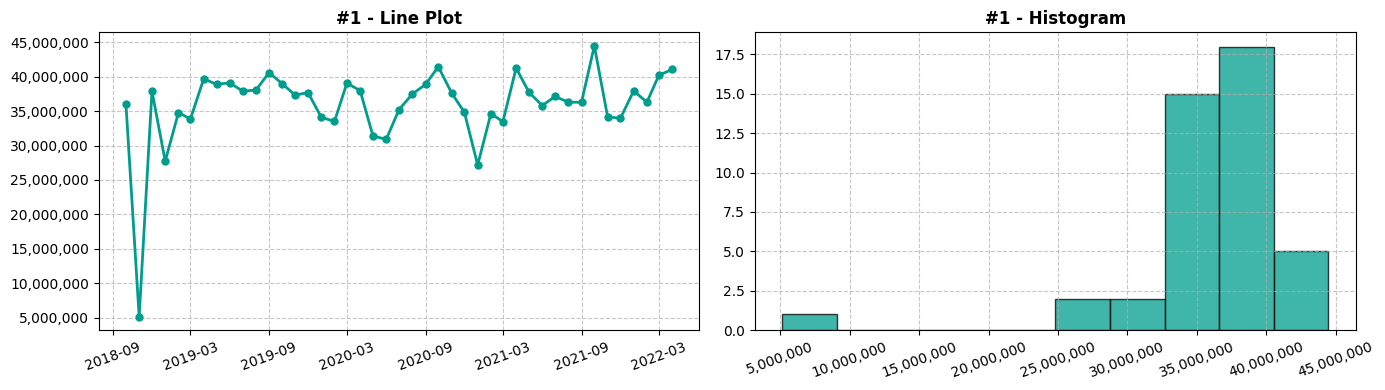

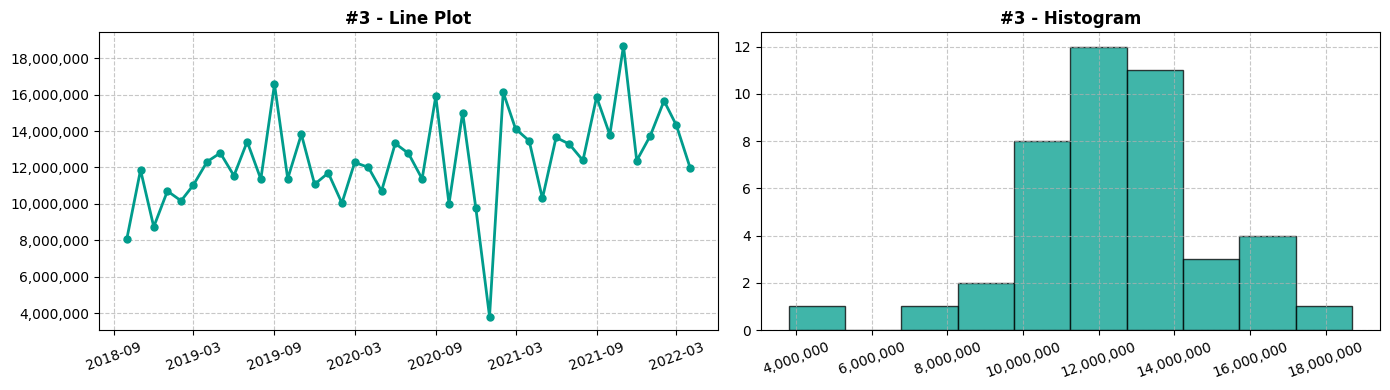

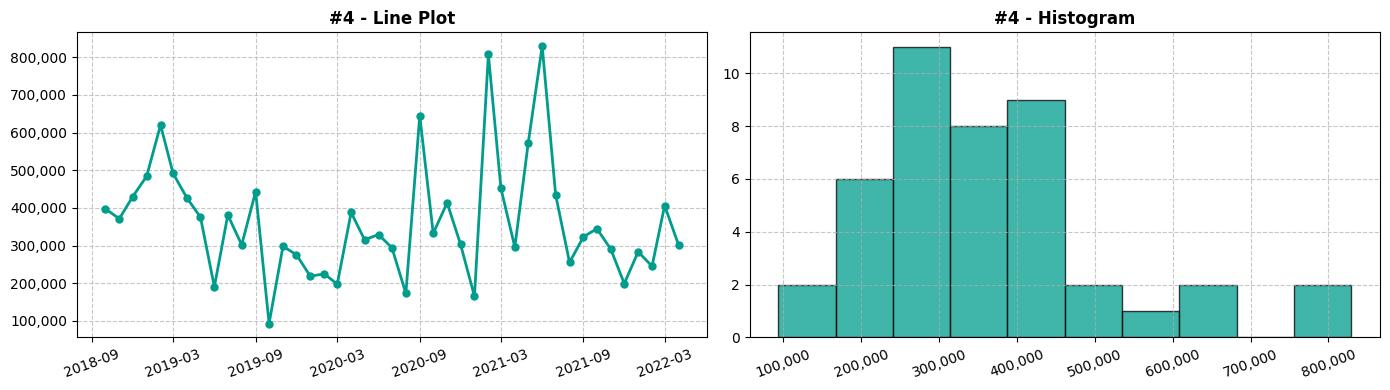

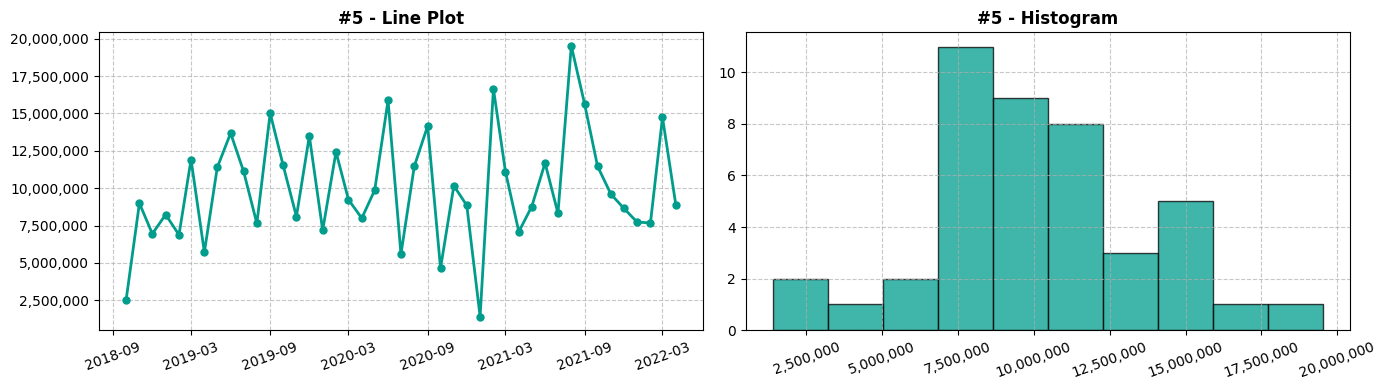

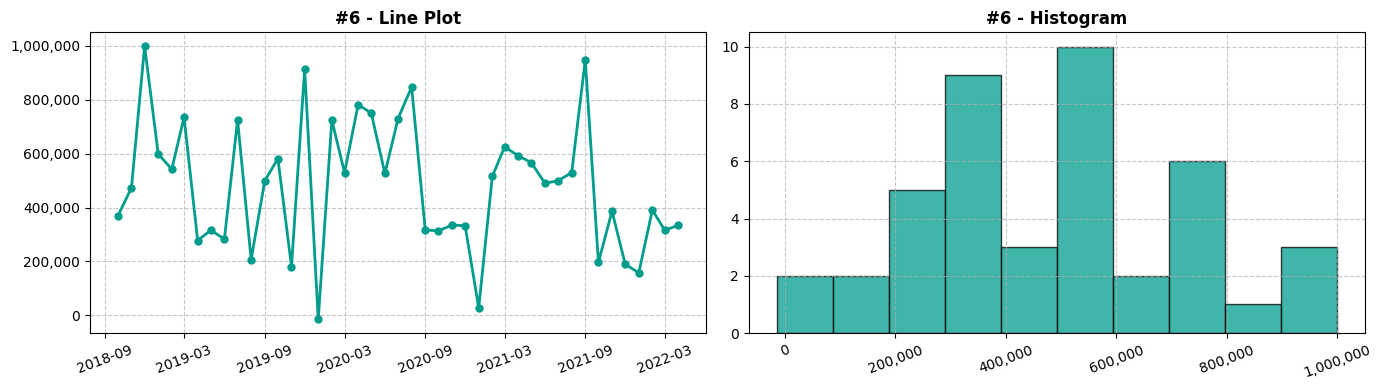

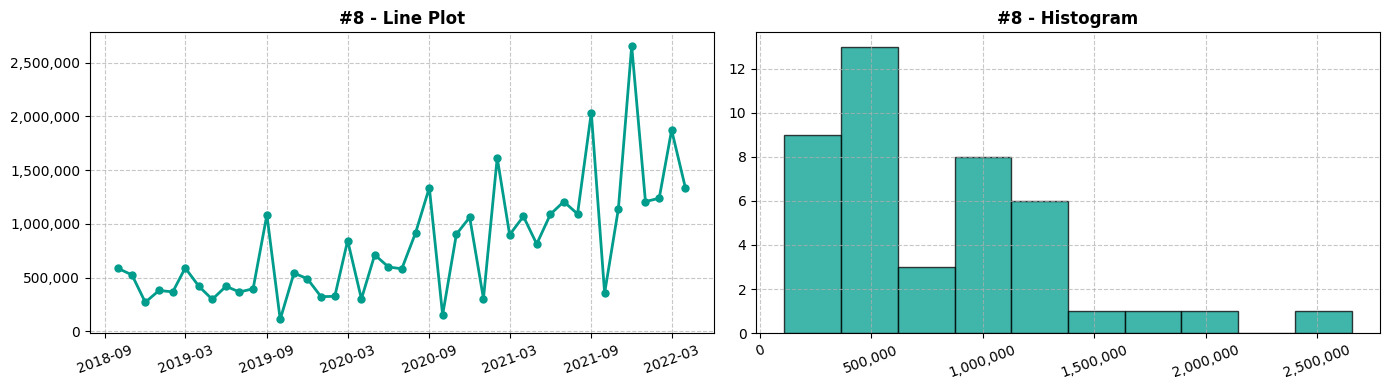

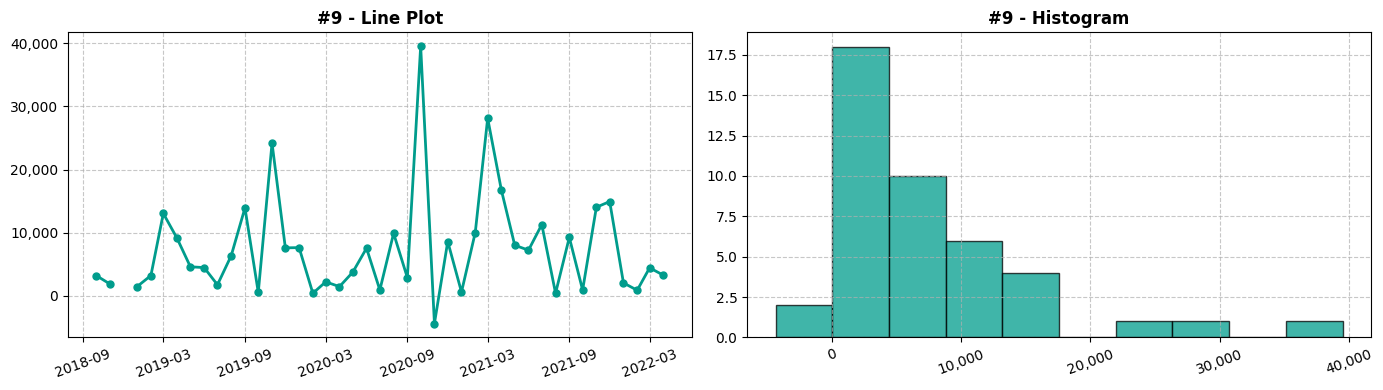

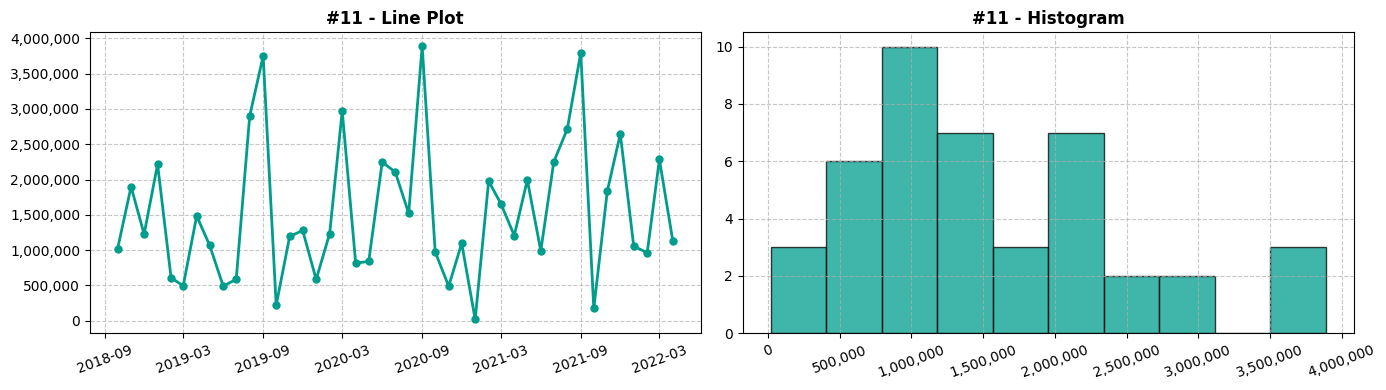

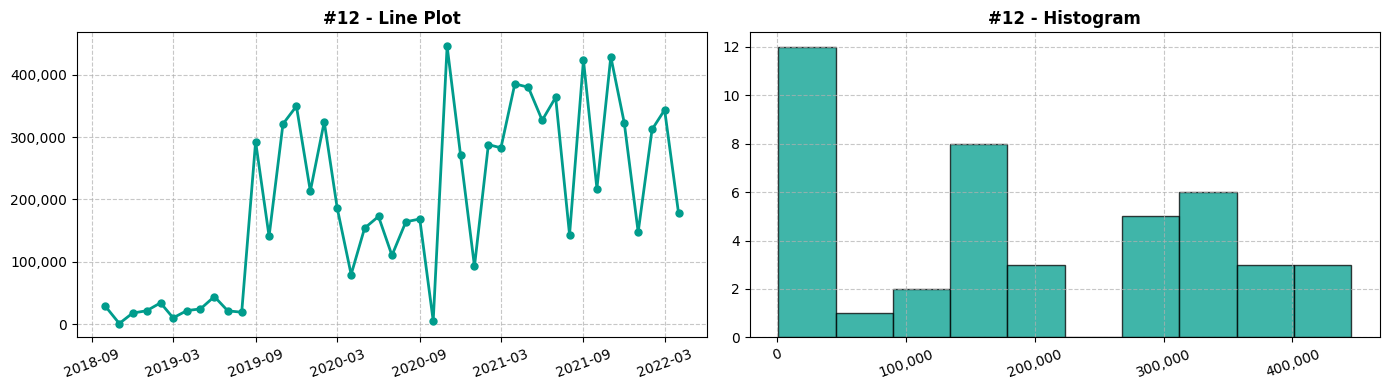

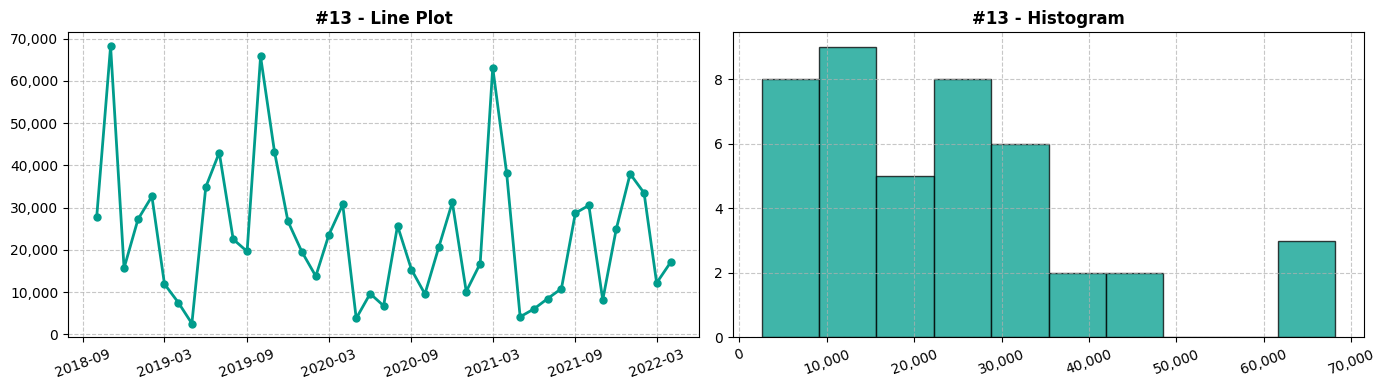

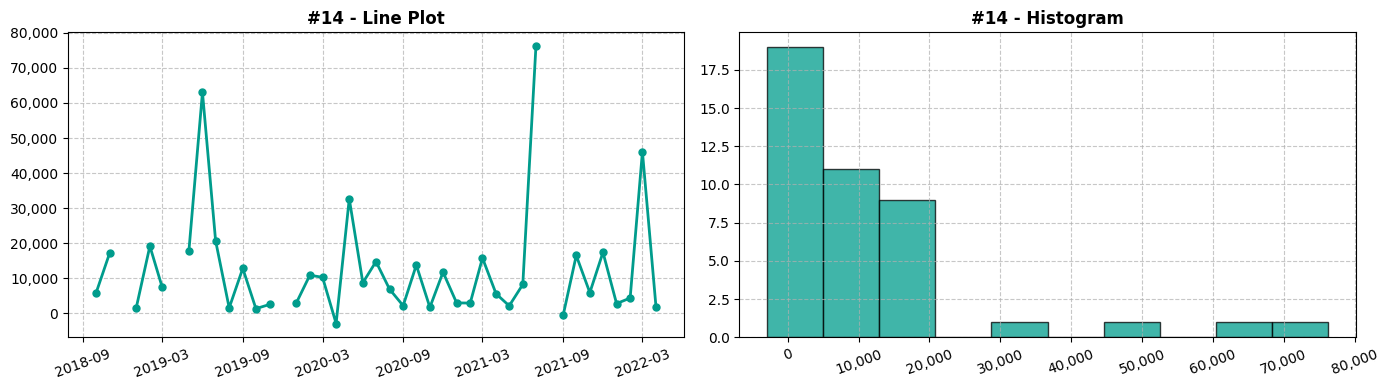

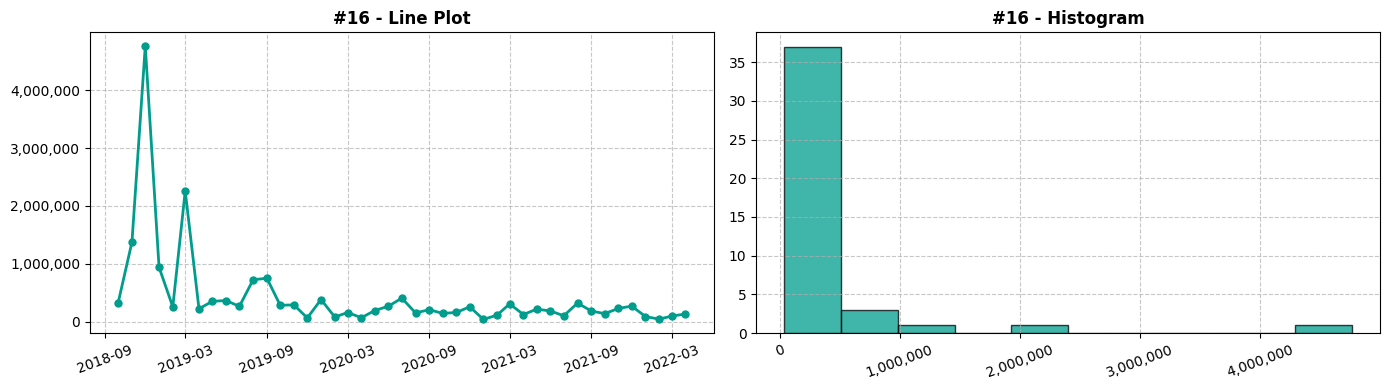

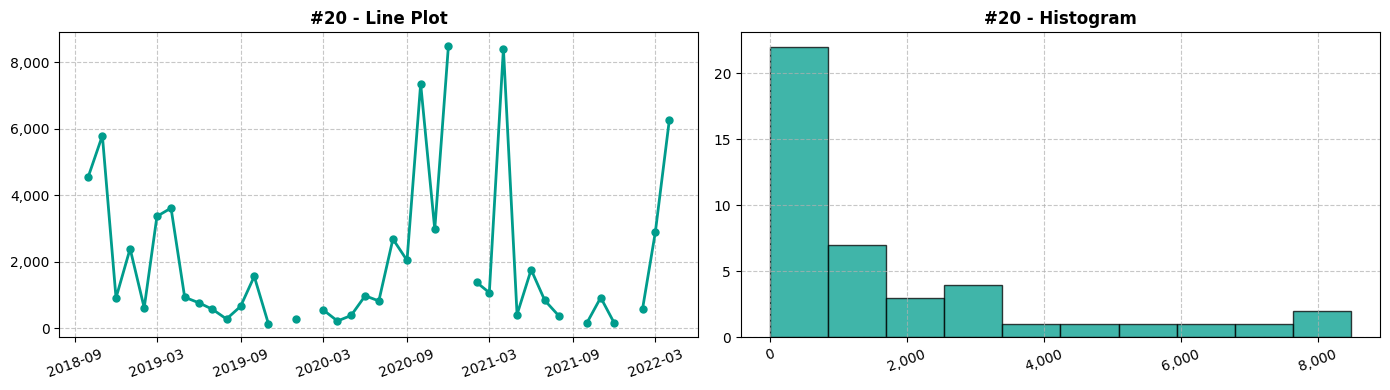

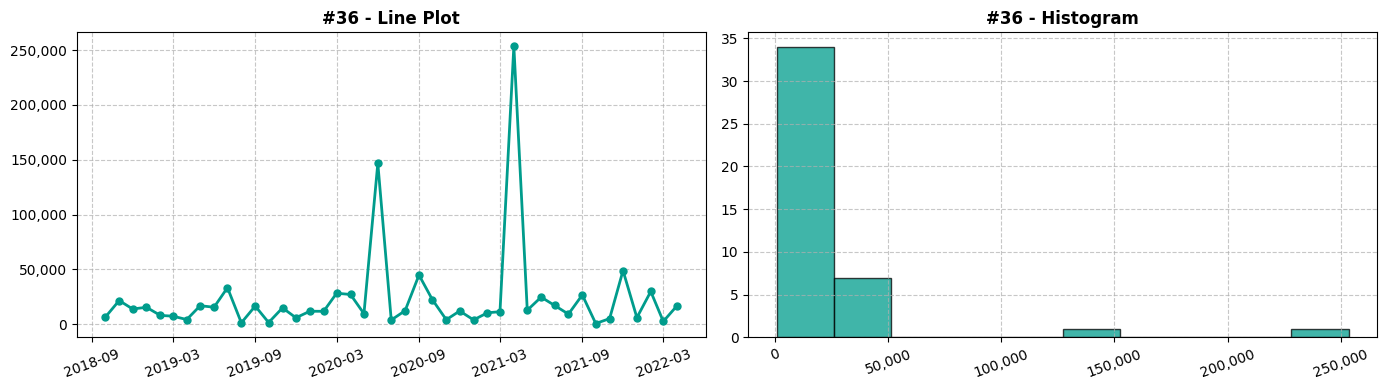

In [25]:
f.plot_sales_data(new_monthly_sales)

##### Notes:

**Product # 1:**

Significant decline on November 2018. According to Siemens’ Annual Report 2018, there was a significant decline in the Power and Gas Division, which specializes in gas turbines. This might be due to the global shift towards renewable energy. In the same report, we can find that “ Volume in that segment declined significantly in fiscal 2018 due mainly to customer delays of large projects in the Americas and in the Middle East and strong price pressure resulting from intense competition.” This could suggest that this product category (#1) is part of th division, although it has not been explicitly confirmed. While we cannot treat this as definitive, it will be taken into account for consideration. The sales in this segment generally range from 35 to 42 million monetary units. October of 2021 had larger sales.

Siemens AG. (2018). Annual report 2018. Siemens AG. https://assets.new.siemens.com/siemens/assets/api/uuid:4bfbab10-00d6-4a22-aad2-b50f3f232bfb/siemens-annual-report-2018.pdf

In [117]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the number of rows and columns
rows, cols = 5, 3

# Create a subplot grid
fig = make_subplots(rows=rows, cols=cols, subplot_titles=new_monthly_sales.columns)

# Flatten the column index for iteration
columns = new_monthly_sales.columns
index_values = new_monthly_sales.index

# Loop through each column and add a trace
for i, column in enumerate(columns):
    row = (i // cols) + 1
    col = (i % cols) + 1

    fig.add_trace(
        go.Scatter(
            x=index_values, 
            y=new_monthly_sales[column], 
            #mode='lines+markers',  # Dotted line with markers
            line=dict(dash='dot', color='black'),  # Dotted line style
            marker=dict(color='black', size=4),
            name=column
        ),
        row=row,
        col=col
    )

# Update layout
fig.update_layout(
    height=1500, width=1200,  # Adjust figure size
    showlegend=False,  # Hide legend to keep it clean
    title_text="Production Shipping Index",
)

# Show figure
fig.show()

In [118]:
# import matplotlib.ticker as mtick
# new_monthly_sales.hist(figsize=(20, 12))
# ax[0].yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
# pyplot.show()

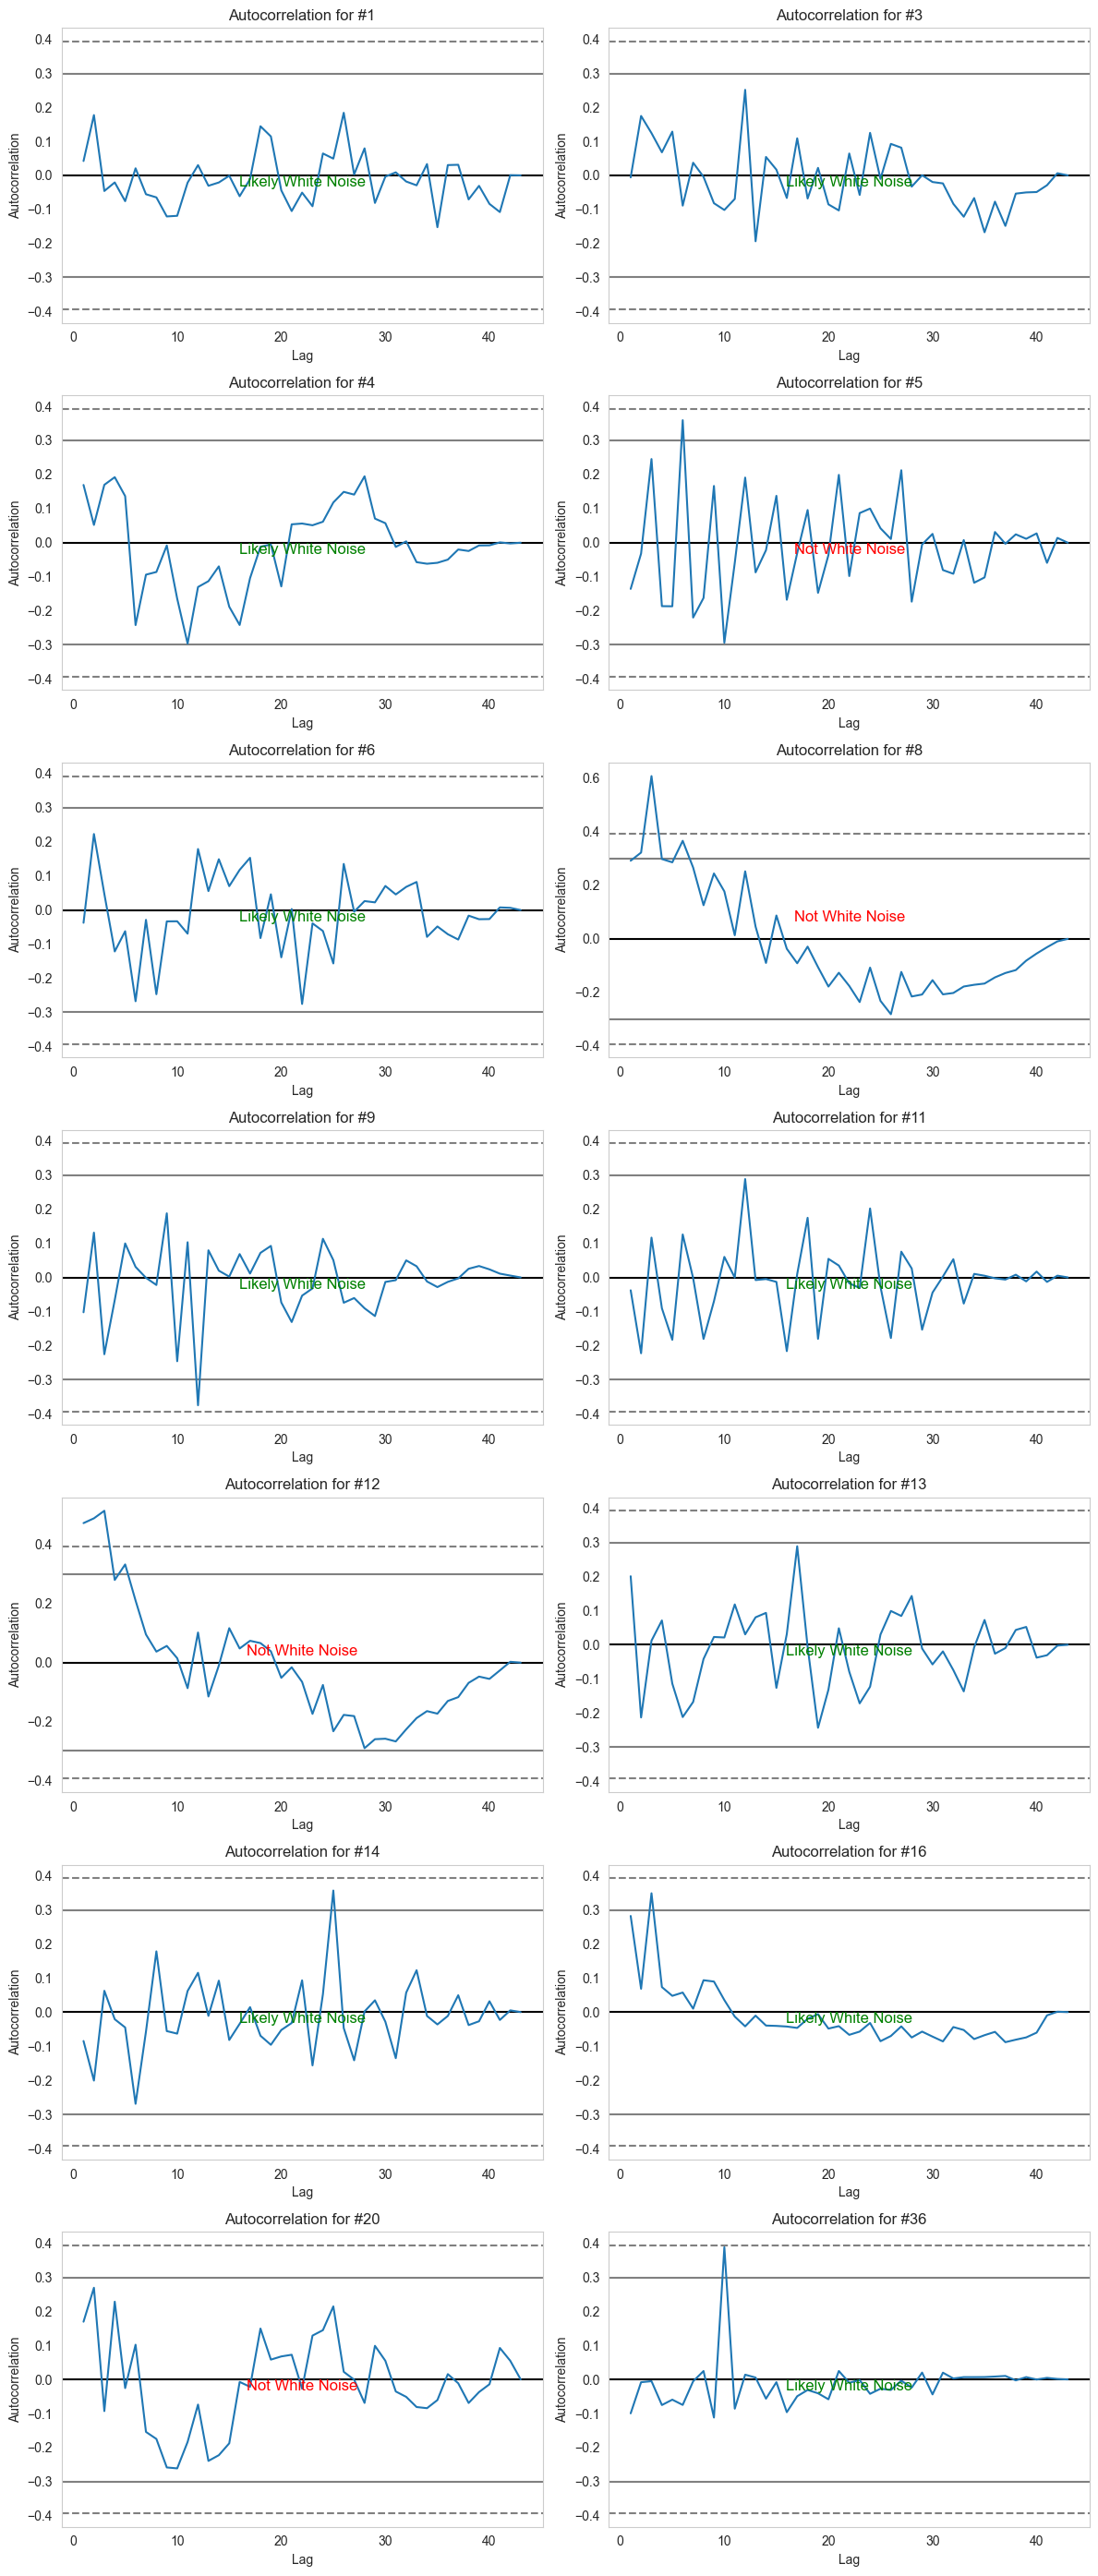

In [119]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np

# Number of columns
num_cols = len(new_monthly_sales.columns)
rows = int(np.ceil(num_cols / 2))  # Arrange subplots in rows of 2

fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))  # Adjust size dynamically
axes = axes.flatten()  # Flatten to easily iterate

for i, column in enumerate(new_monthly_sales.columns):
    autocorrelation_plot(new_monthly_sales[column], ax=axes[i])  # Plot ACF
    axes[i].set_title(f"Autocorrelation for {column}")

    # Ljung-Box Test
    lb_test = acorr_ljungbox(new_monthly_sales[column], lags=[10], return_df=True)
    p_value = lb_test['lb_pvalue'].values[0]

    # Add white noise indication
    if p_value > 0.05:
        axes[i].text(0.5, 0.5, "Likely White Noise", ha='center', va='top', 
                     fontsize=12, color='green', transform=axes[i].transAxes)
    else:
        axes[i].text(0.5, 0.5, "Not White Noise", ha='center', va='top', 
                     fontsize=12, color='red', transform=axes[i].transAxes)

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [120]:
f.plot_boxplots(new_monthly_sales)

<br>

**Market Data**

In [121]:
if isinstance(market_data.index, pd.PeriodIndex):
    market_data.index = market_data.index.to_timestamp()
market_data_resampled = market_data.resample('MS').sum()

In [122]:
resources_prices = [
    '(W) Price of Base Metals', '(W) Price of Energy', '(W) Price of Metals & Minerals',
    '(W) Price of Natural gas index', '(W) Price of Crude oil, average', '(W) Price of Copper'
]

f.resource_prices(market_data_resampled, resources_prices)


In [123]:
prod_ship_index = market_data_resampled.iloc[:, 0:18] 

In [124]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the number of rows and columns
rows, cols = 6, 3

# Create a subplot grid
fig = make_subplots(rows=rows, cols=cols, subplot_titles=prod_ship_index.columns)

# Flatten the column index for iteration
columns = prod_ship_index.columns
index_values = prod_ship_index.index

# Loop through each column and add a trace
for i, column in enumerate(columns):
    row = (i // cols) + 1
    col = (i % cols) + 1

    fig.add_trace(
        go.Scatter(
            x=index_values, 
            y=prod_ship_index[column], 
            mode='lines+markers',  # Dotted line with markers
            line=dict(dash='dot', color='black'),  # Dotted line style
            marker=dict(color='black', size=4),
            name=column
        ),
        row=row,
        col=col
    )

# Update layout
fig.update_layout(
    height=1500, width=1200,  # Adjust figure size
    showlegend=False,  # Hide legend to keep it clean
    title_text="Production Shipping Index",
)

# Show figure
fig.show()

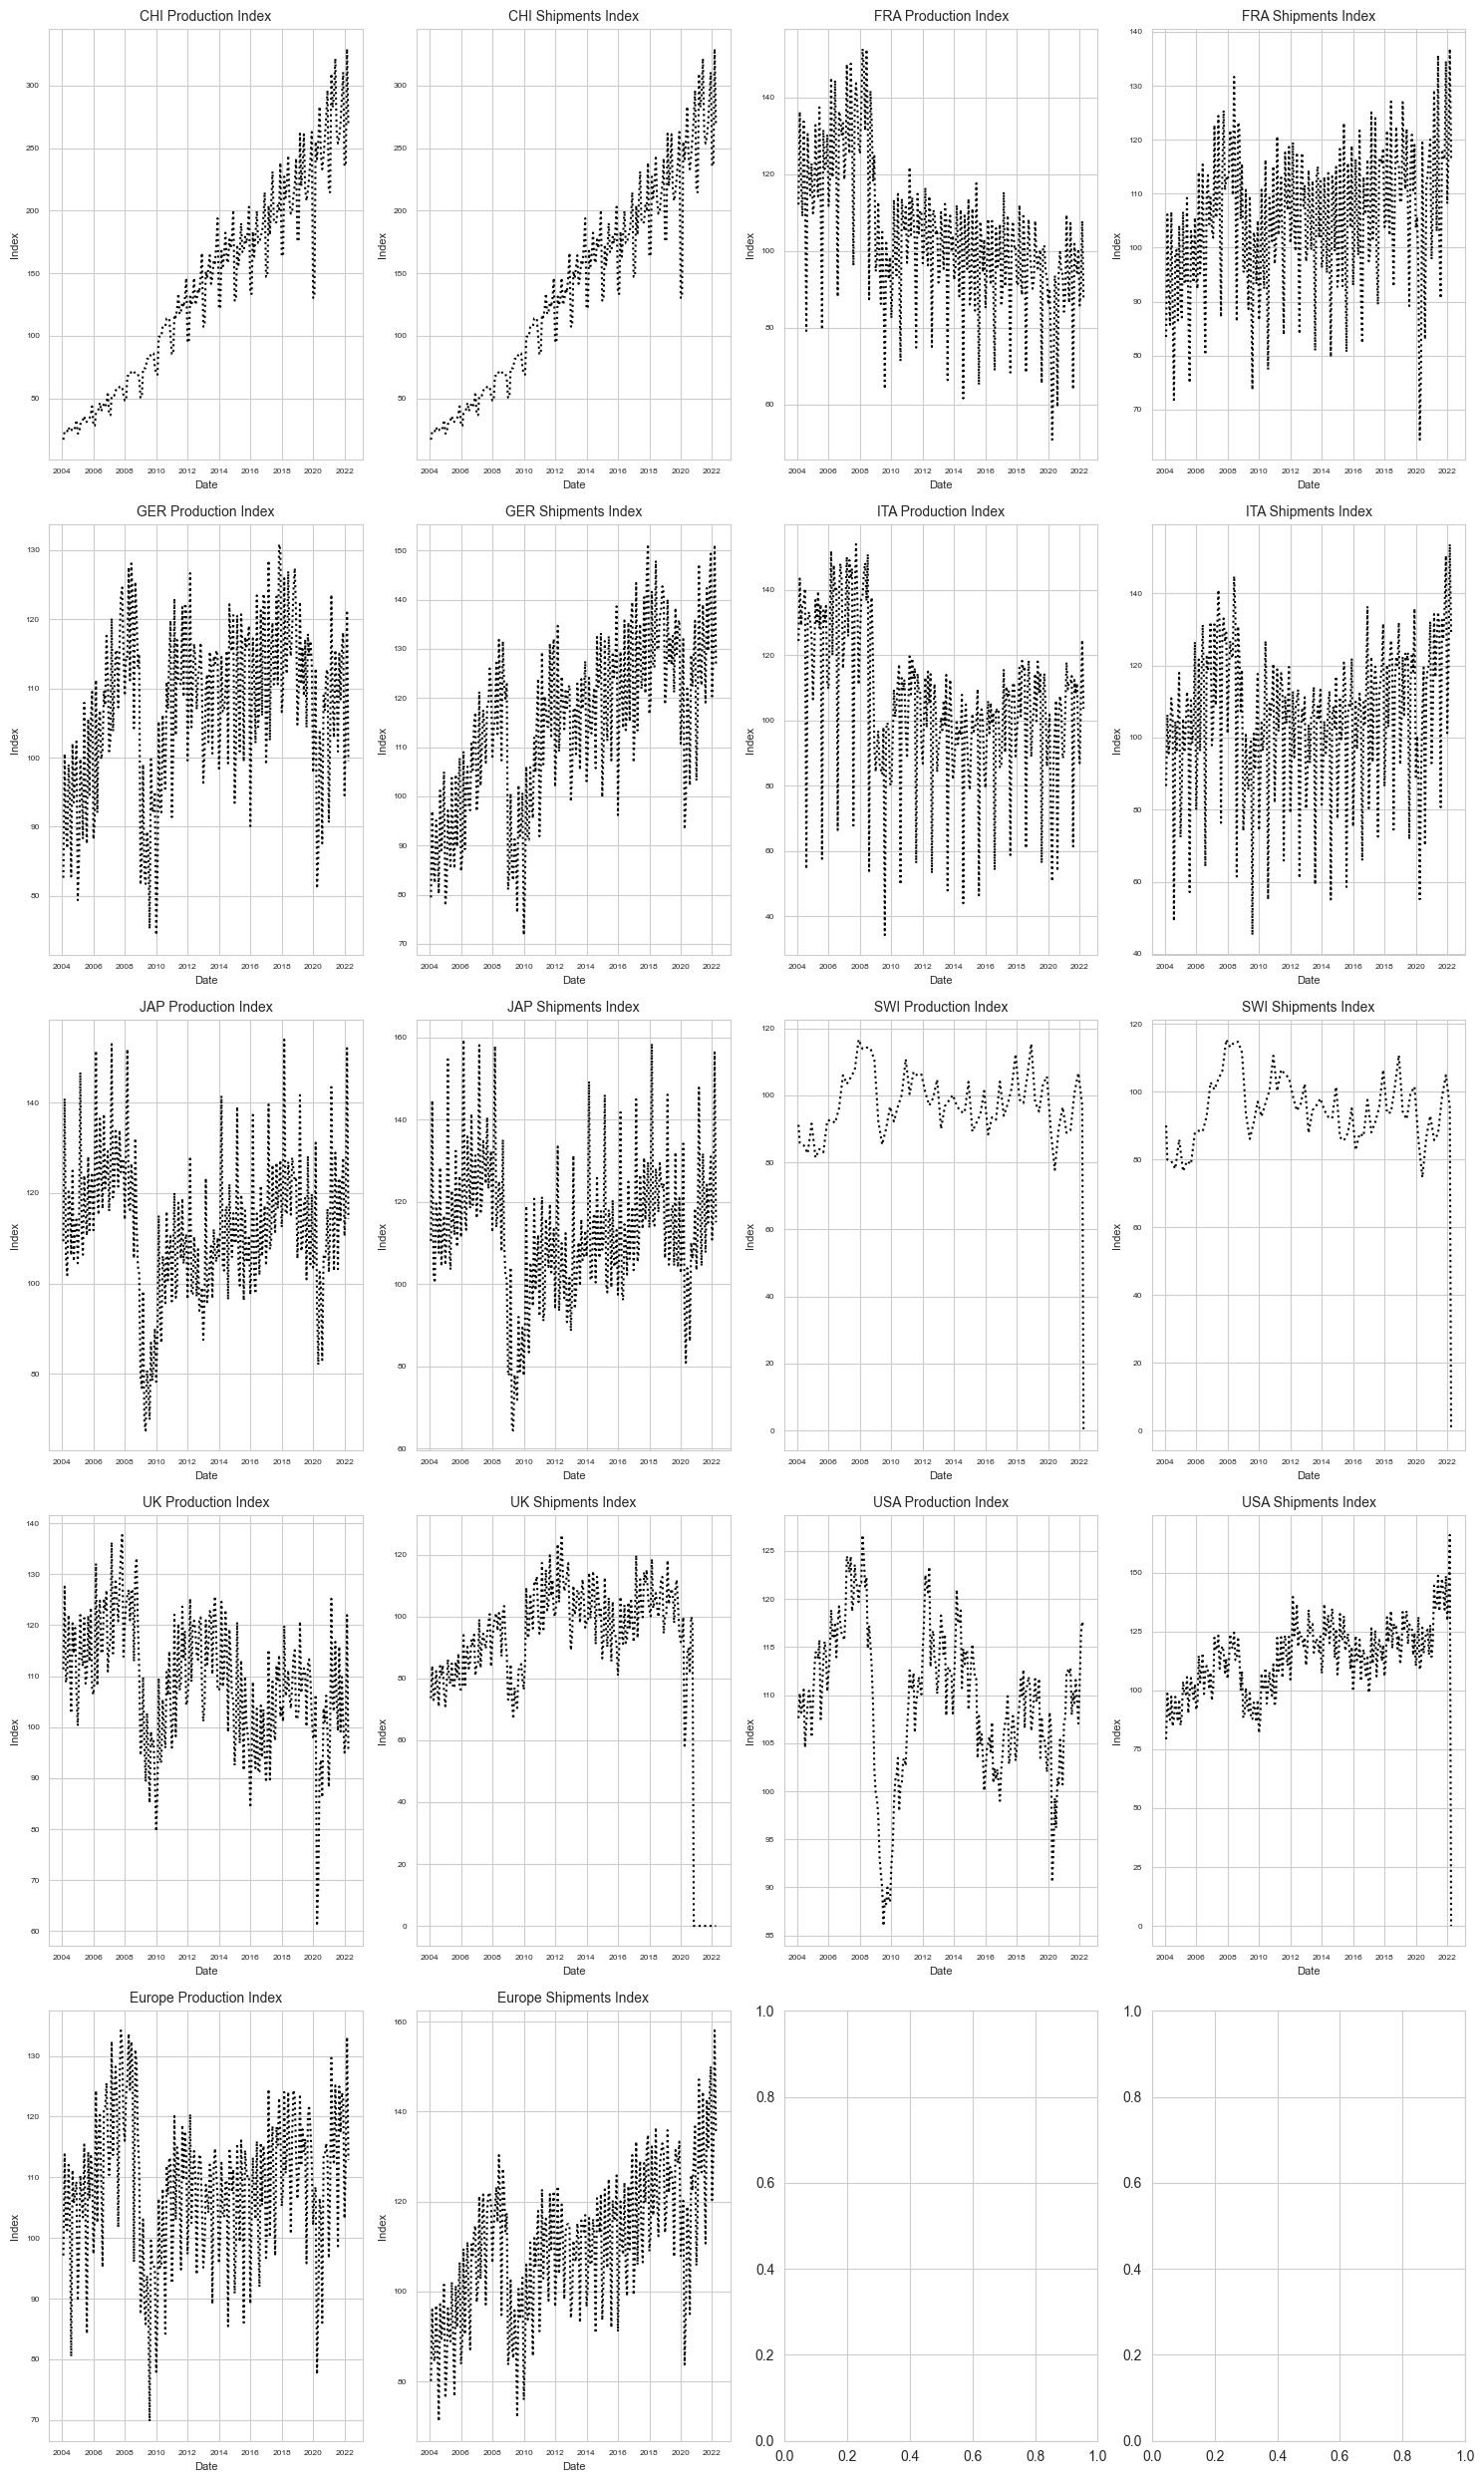

In [125]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 25))

axes = axes.flatten()

for i, column in enumerate(prod_ship_index.columns):  
    ax = axes[i]
    ax.plot(prod_ship_index.index, prod_ship_index[column], 'k:')  
    ax.set_title(column, fontsize=10)
    ax.set_xlabel('Date', fontsize=8)
    ax.set_ylabel('Index', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [126]:
production_columns = [
    'CHI Production Index', 'FRA Production Index', 'GER Production Index', 
    'ITA Production Index', 'JAP Production Index', 'SWI Production Index',
    'UK Production Index', 'USA Production Index', 'Europe Production Index'
]
production_data = market_data_resampled[production_columns]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in production_columns:
    trace = go.Scatter(
        x=production_data.index,  
        y=production_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title="Production Index Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Production Index'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

In [127]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume 'market_data_resampled' is already loaded and indexed by date
production_columns = [
    'CHI Production Index', 'FRA Production Index', 'GER Production Index', 
    'ITA Production Index', 'JAP Production Index', 'SWI Production Index',
    'UK Production Index', 'USA Production Index', 'Europe Production Index'
]

# Define a fixed color mapping for each country
color_map = {
    'CHI Production Index': 'red',
    'FRA Production Index': 'blue',
    'GER Production Index': 'green',
    'ITA Production Index': 'purple',
    'JAP Production Index': 'orange',
    'SWI Production Index': 'pink',
    'UK Production Index': 'brown',
    'USA Production Index': 'black',
    'Europe Production Index': 'cyan'
}

# Extract year from index and group by it
production_data = market_data_resampled[production_columns].copy()
production_data['Year'] = production_data.index.year  # Extract year from datetime index
groups = production_data.groupby('Year')

# Create subplots (one for each year)
fig = make_subplots(rows=len(groups), cols=1, subplot_titles=[str(year) for year in groups.groups.keys()])

# Track which countries have been added to the legend
legend_added = set()

# Loop through each year and plot the data with consistent colors
for i, (year, group) in enumerate(groups, start=1):
    for country in production_columns:
        fig.add_trace(
            go.Scatter(
                x=group.index, 
                y=group[country], 
                mode='lines', 
                name=country,  # Use only country name in legend
                line=dict(color=color_map[country]),  
                showlegend=(country not in legend_added)  # Show legend only once
            ),
            row=i, col=1
        )
        legend_added.add(country)  # Mark this country as added

# Update layout
fig.update_layout(
    title="Production Index Over Time by Country (Grouped by Year)",
    height=310 * len(groups),  # Adjust height dynamically based on the number of years
    xaxis_title="Date",
    yaxis_title="Production Index",
    showlegend=True,  # Ensure the legend is visible
    legend=dict(
        orientation='h',  # Horizontal legend
        y=1.00 ,  # Position the legend just below the title, slightly above the first plot
        x=0.5,  # Center the legend horizontally
        xanchor='center',  # Anchor the x position at the center
        yanchor='bottom'  # Anchor the y position at the bottom
    ),
    margin=dict(t=90, b=60, l=60, r=60)  # Adjust margin to create space for the legend between the title and first graph
)

# Show plot
fig.show()

In [128]:
producer_prices = ['USA EE Producer Prices', 'UK EE Producer Prices',
                     'ITA EE Producer Prices', 'FRA EE Producer Prices',
                     'GER EE Producer Prices', 'CHI EE Producer Prices',
]
producer_price_data = market_data_resampled[producer_prices]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in producer_prices:
    trace = go.Scatter(
        x=producer_price_data.index,  
        y=producer_price_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title="Producer Price Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Production Price'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

In [129]:
shipment_columns = [
    'CHI Shipments Index', 'FRA Shipments Index', 'GER Shipments Index', 
    'ITA Shipments Index', 'JAP Shipments Index', 'SWI Shipments Index',
    'UK Shipments Index', 'USA Shipments Index', 'Europe Shipments Index'
]
shipment_data = market_data_resampled[shipment_columns]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in shipment_columns:
    trace = go.Scatter(
        x=shipment_data.index,  
        y=shipment_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title="Shipment Index Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Shipment Index'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

In [130]:
me_index = ['USA Machinery & Equipment Index', '(W) Machinery & Equipment Index',
       'SWI Machinery & Equipment Index', 'UK Machinery & Equipment Index',
       'ITA Machinery & Equipment Index', 'JAP Machinery & Equipment Index',
       'FRA Machinery & Equipment Index', 'GER Machinery & Equipment Index'
]

me_index_data = market_data_resampled[me_index]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in me_index:
    trace = go.Scatter(
        x=me_index_data.index,  
        y=me_index_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title=" Machinery & Equipment Index Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Index'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

In [131]:
ee_index = ['USA EE Production Index', '(W) EE Production Index',
       'SWI EE Production Index', 'UK EE Production Index',
       'ITA EE Production Index', 'JAP EE Production Index',
       'FRA EE Production Index', 'GER EE Production Index'
]

ee_index_data = market_data_resampled[ee_index]

# Create an empty list for traces
traces = []

# Create a trace for each country
for country in ee_index:
    trace = go.Scatter(
        x=ee_index_data.index,  
        y=ee_index_data[country],  
        mode='lines', 
        name=country 
    )
    traces.append(trace)

# Define the layout
layout = go.Layout(
    title=" Eletronic Index Over Time by Country",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Index'),
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

## 4.2 Bivariate Analysis

<a href="#top">Top &#129033;</a>

**Sales Data**

Percentage of each product per year

In [132]:
copy = new_monthly_sales.copy().reset_index()
copy["Year"] = copy["Date"].dt.year
copy = copy.drop(columns=["Date"])
yearly_data = copy.groupby("Year").sum()
df_percent = yearly_data.div(yearly_data.sum(axis=1), axis=0) * 100
df_percent = df_percent.round(0).astype(int).astype(str) + "%"
df_percent


Mapped_GCK   #1   #3  #4   #5  #6  #8  #9 #11 #12 #13 #14 #16 #20 #36
Year                                                                 
2018        56%  20%  1%  13%  1%  1%  0%  3%  0%  0%  0%  5%  0%  0%
2019        59%  19%  1%  16%  1%  1%  0%  2%  0%  0%  0%  1%  0%  0%
2020        59%  20%  1%  16%  1%  1%  0%  3%  0%  0%  0%  0%  0%  0%
2021        56%  20%  1%  17%  1%  2%  0%  3%  0%  0%  0%  0%  0%  0%
2022        59%  21%  0%  15%  0%  2%  0%  2%  0%  0%  0%  0%  0%  0%

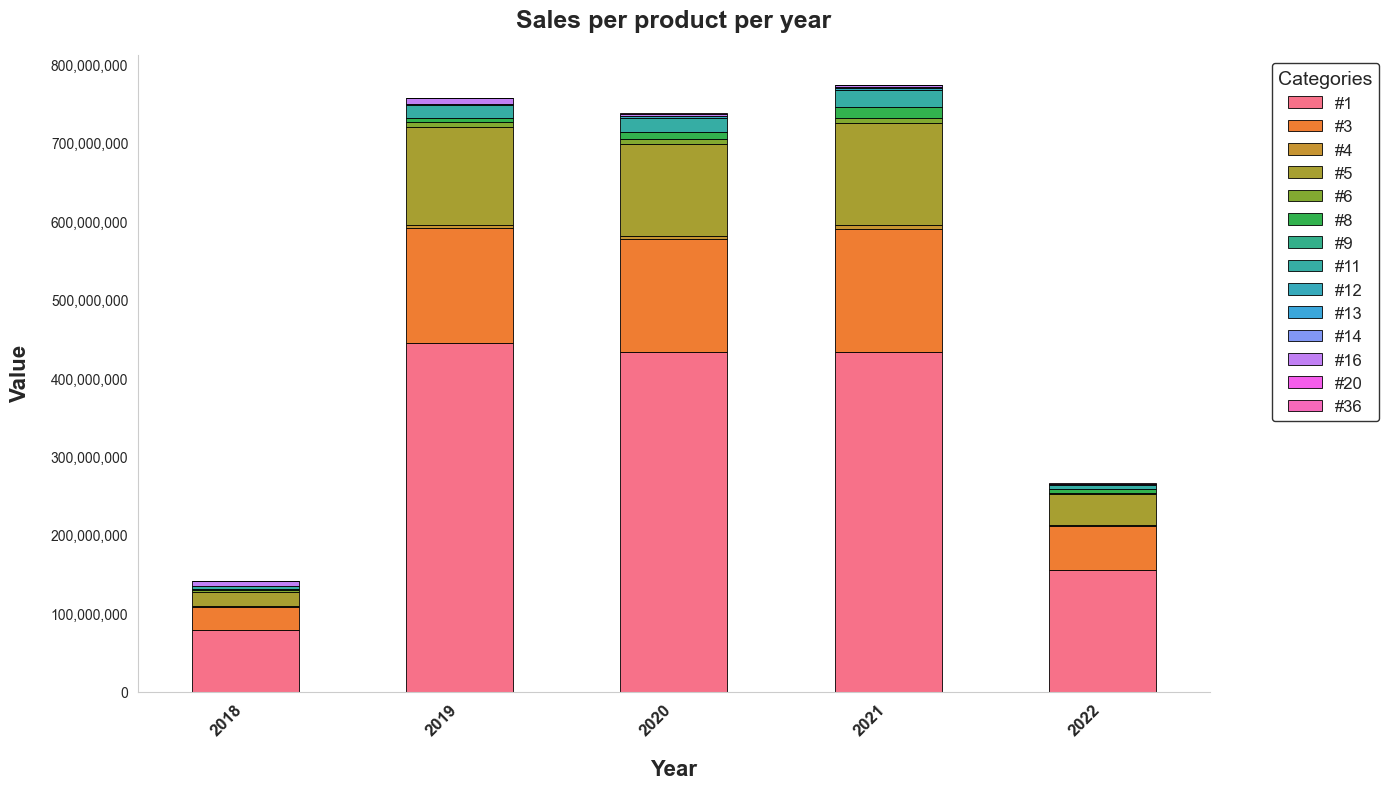

In [133]:
f.plot_stacked_bar(yearly_data)

Pairwise relationship between products

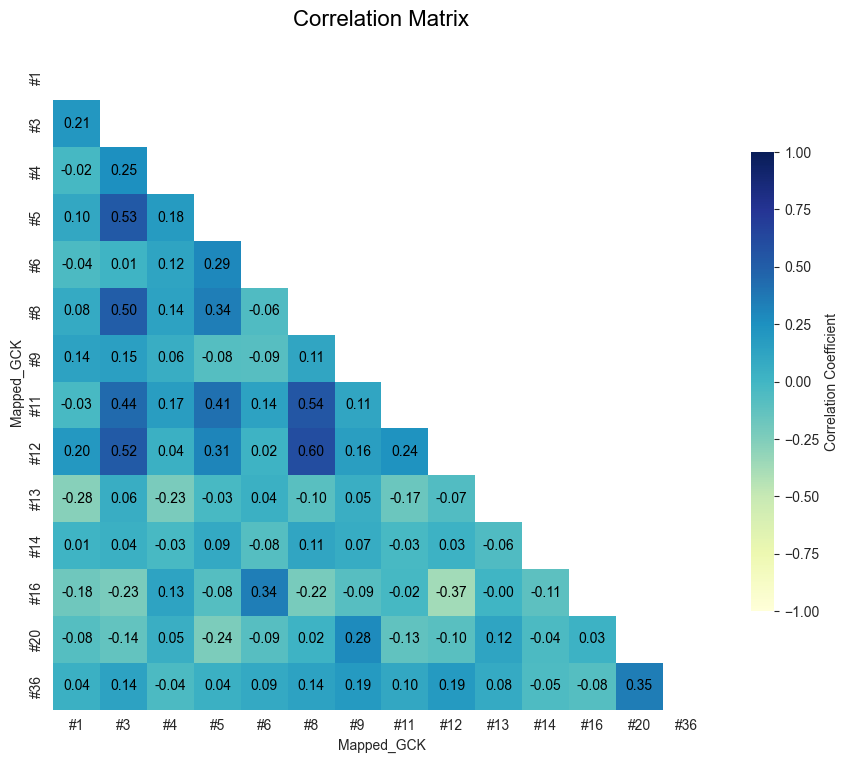

In [134]:
corr = np.round(new_monthly_sales.corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

In [135]:
f.plot_high_correlation_pairs(new_monthly_sales)

In [136]:
fig = f.monthly_sales_per_year(new_monthly_sales)
fig.show()

ver sales trend por year

In [137]:
f.monthly_sales(new_monthly_sales)

In [138]:
f.percentage_change(new_monthly_sales)

In [139]:
f.percentage_change_previous_month(new_monthly_sales)

https://online.stat.psu.edu/stat510/lesson/5/5.1

In [140]:
f.multiplicative_seasonal_decomposition(new_monthly_sales, excluded_columns=['#14', '#20', '#6', '#9'])

Dropdown(description='Select Column:', options=('#1', '#3', '#4', '#5', '#8', '#11', '#12', '#13', '#16', '#36…

Output()

In [141]:
f.additive_seasonal_decomposition(new_monthly_sales, excluded_columns=['#14', '#20', '#6', '#9'])

Dropdown(description='Select Column:', options=('#1', '#3', '#4', '#5', '#8', '#11', '#12', '#13', '#16', '#36…

Output()

<br>

**Market Data**

Production and Shipment Index

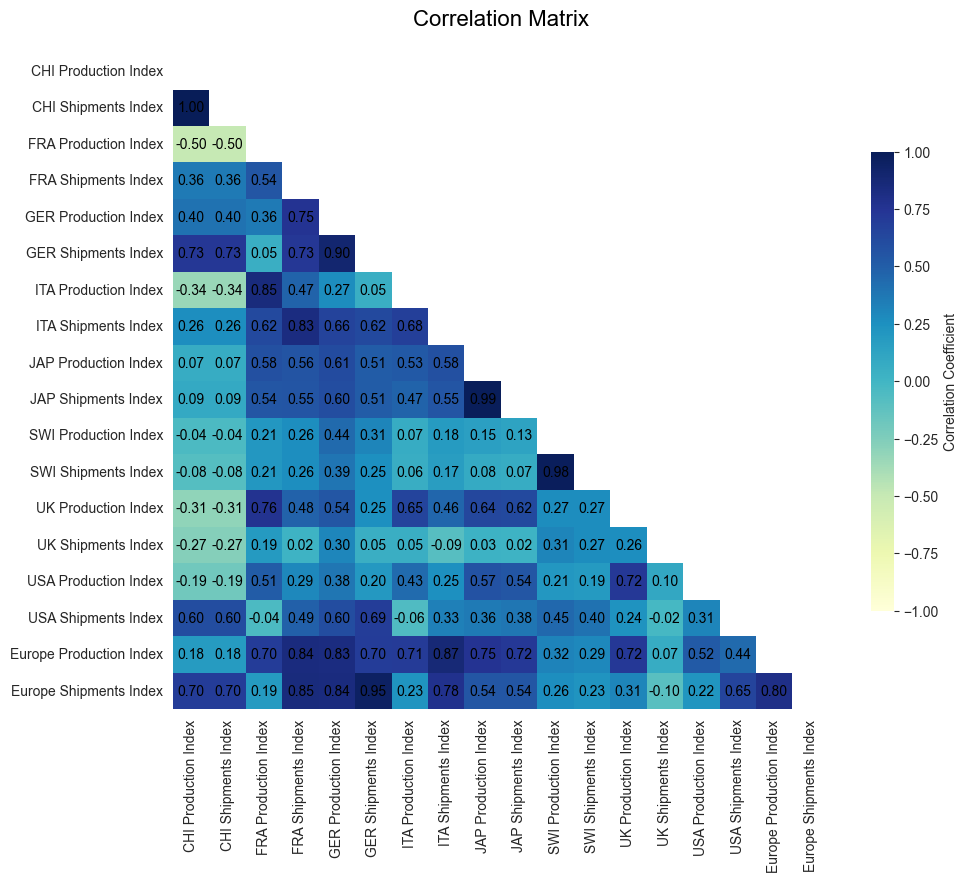

In [142]:
prod_ship_index = market_data_resampled.iloc[:, 0:18] 
corr = np.round(prod_ship_index.corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

Prices Indexes

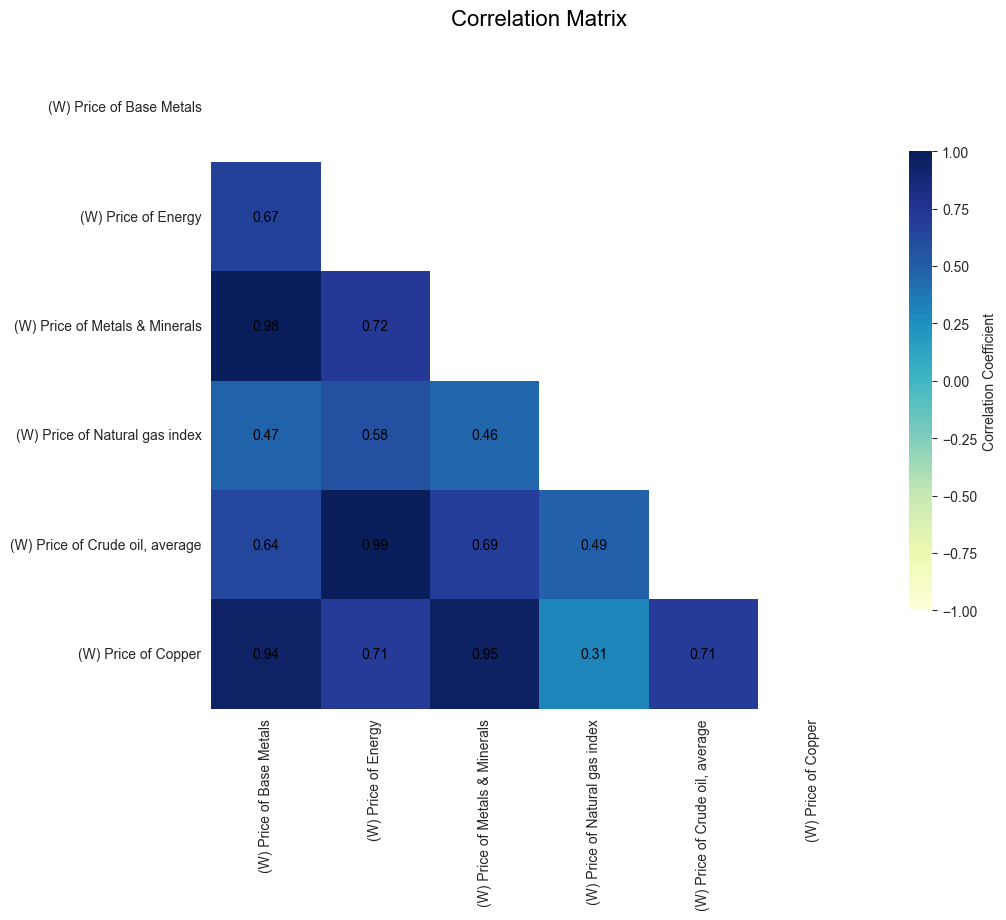

In [143]:
corr = np.round(market_data_resampled[resources_prices].corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

Producer Prices Electrical Equipment

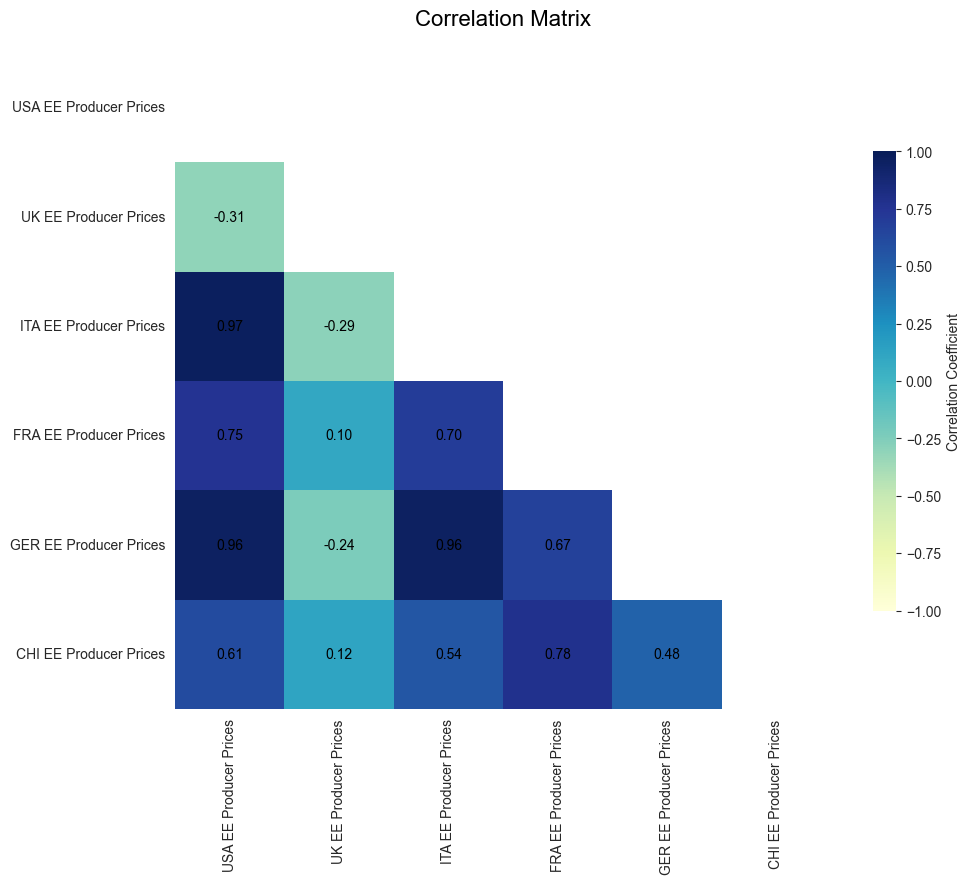

In [144]:
corr = np.round(market_data_resampled[producer_prices].corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

Production Index Machinery Equipment

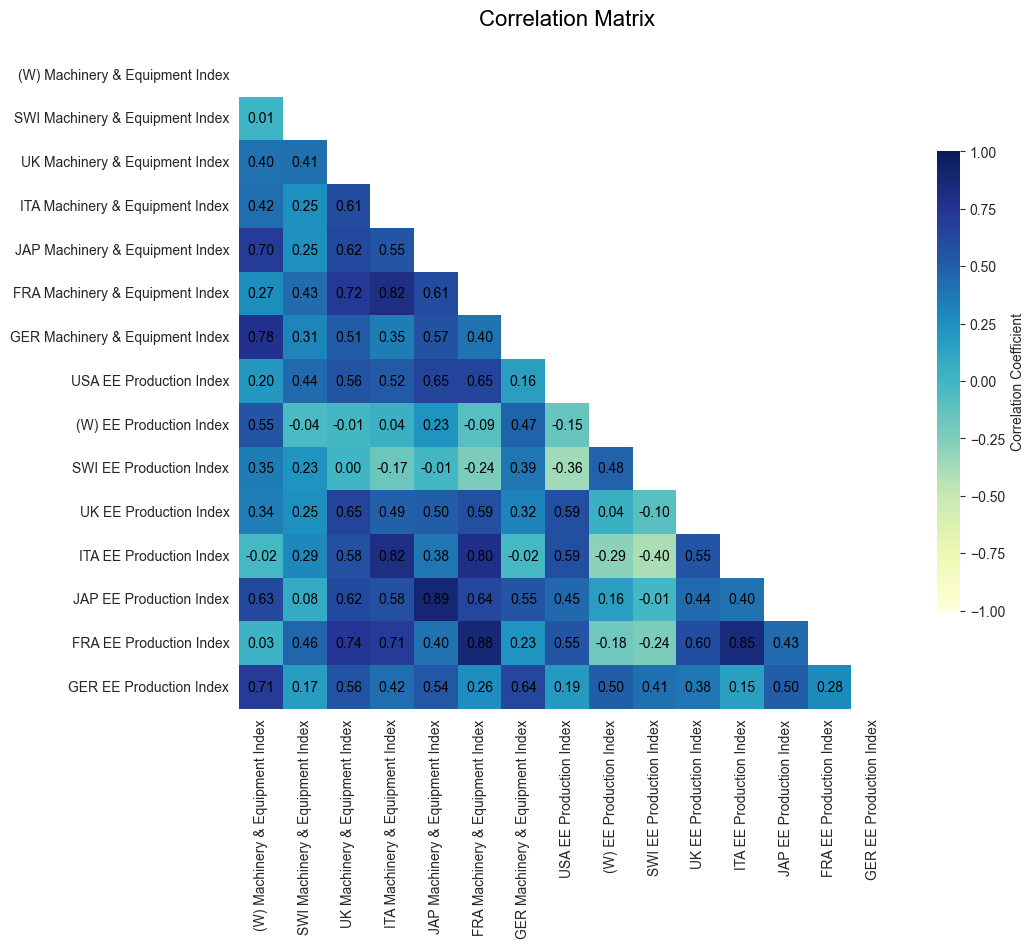

In [145]:
production_index_me_ee = market_data_resampled.iloc[:, 32:49] 
corr = np.round(production_index_me_ee.corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='YlGnBu', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "black", "ha": "center", "va": "center"},  
            linecolor='white')  

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

<br>

### 4.2.1 Germany's market

In [146]:
ger_columns = market_data_resampled.filter(like='GER', axis=1)
ger_columns.head()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
Date                                                                            
2004-02-01                 82.62                79.45                   93.23   
2004-03-01                100.56                97.01                   93.34   
2004-04-01                 89.65                84.93                   93.44   
2004-05-01                 86.88                82.37                   93.55   
2004-06-01                 99.01                95.11                   93.44   

            GER Machinery & Equipment Index  GER EE Production Index  
Date                                                                  
2004-02-01                            80.83                    85.91  
2004-03-01                           102.13                    97.67  
2004-04-01                            90.96                    87.25  
2004-05-01                            88.08                    84.68  
2004-06-01                           100.98                    95.40

In [147]:
# Filter the rows between 2018 and the end of the dataset
filtered_ger_columns = ger_columns[ger_columns.index.year >= 2018]
filtered_ger_columns.head()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
Date                                                                            
2018-01-01                106.60               116.72                  107.86   
2018-02-01                109.38               119.49                  107.86   
2018-03-01                125.95               141.75                  108.17   
2018-04-01                113.47               126.38                  108.17   
2018-05-01                112.10               126.24                  108.28   

            GER Machinery & Equipment Index  GER EE Production Index  
Date                                                                  
2018-01-01                           104.55                   110.36  
2018-02-01                           110.54                   107.26  
2018-03-01                           130.80                   117.06  
2018-04-01                           116.06                   108.71  
2018-05-01                           115.03                   106.75

In [148]:
# check the germany_market DataFrame information
filtered_ger_columns.describe()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
count                 52.00                52.00                   52.00   
mean                 109.96               128.13                  111.35   
std                   10.39                12.62                    2.99   
min                   81.06                93.29                  107.86   
25%                  103.92               120.93                  109.83   
50%                  111.39               129.13                  110.59   
75%                  116.76               136.90                  111.80   
max                  127.40               151.20                  121.22   

       GER Machinery & Equipment Index  GER EE Production Index  
count                            52.00                    52.00  
mean                            113.10                   104.20  
std                              12.90                     9.28  
min                              81.06                    81.07  
25%                             104.35                    99.55  
50%                             115.03                   106.18  
75%                             122.37                   110.12  
max                             137.36                   119.95

In [149]:
f.resource_prices(filtered_ger_columns, filtered_ger_columns.columns)

Germany vs Europe

In [150]:
ger_columns = market_data_resampled.filter(like='GER', axis=1)
ger_columns.head()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
Date                                                                            
2004-02-01                 82.62                79.45                   93.23   
2004-03-01                100.56                97.01                   93.34   
2004-04-01                 89.65                84.93                   93.44   
2004-05-01                 86.88                82.37                   93.55   
2004-06-01                 99.01                95.11                   93.44   

            GER Machinery & Equipment Index  GER EE Production Index  
Date                                                                  
2004-02-01                            80.83                    85.91  
2004-03-01                           102.13                    97.67  
2004-04-01                            90.96                    87.25  
2004-05-01                            88.08                    84.68  
2004-06-01                           100.98                    95.40

In [151]:
# Filter the rows between 2018 and the end of the dataset
filtered_ger_columns = ger_columns[ger_columns.index.year >= 2018]
filtered_ger_columns.head()

GER Production Index  GER Shipments Index  GER EE Producer Prices  \
Date                                                                            
2018-01-01                106.60               116.72                  107.86   
2018-02-01                109.38               119.49                  107.86   
2018-03-01                125.95               141.75                  108.17   
2018-04-01                113.47               126.38                  108.17   
2018-05-01                112.10               126.24                  108.28   

            GER Machinery & Equipment Index  GER EE Production Index  
Date                                                                  
2018-01-01                           104.55                   110.36  
2018-02-01                           110.54                   107.26  
2018-03-01                           130.80                   117.06  
2018-04-01                           116.06                   108.71  
2018-05-01                           115.03                   106.75

<div class="alert-danger">

Falta copiar os gráficos que estavam no *explore*

# 5. Data Cleaning & Preprocessing

<a href="#top">Top &#129033;</a>

## 5.1 Duplicates

**Sales Data**

In [117]:
new_monthly_sales[new_monthly_sales.duplicated()]

Empty DataFrame
Columns: [#1, #3, #4, #5, #6, #8, #9, #11, #12, #13, #14, #16, #20, #36]
Index: []

**Market Data**

In [118]:
market_data[market_data.duplicated()]

Empty DataFrame
Columns: [CHI Production Index, CHI Shipments Index, FRA Production Index, FRA Shipments Index, GER Production Index, GER Shipments Index, ITA Production Index, ITA Shipments Index, JAP Production Index, JAP Shipments Index, SWI Production Index, SWI Shipments Index, UK Production Index, UK Shipments Index, USA Production Index, USA Shipments Index, Europe Production Index, Europe Shipments Index, (W) Price of Base Metals, (W) Price of Energy, (W) Price of Metals & Minerals, (W) Price of Natural gas index, (W) Price of Crude oil, average, (W) Price of Copper, USA EUR to LCU Conversion Rate , USA EE Producer Prices, UK EE Producer Prices, ITA EE Producer Prices, FRA EE Producer Prices, GER EE Producer Prices, CHI EE Producer Prices, USA Machinery & Equipment Index, (W) Machinery & Equipment Index, SWI Machinery & Equipment Index, UK Machinery & Equipment Index, ITA Machinery & Equipment Index, JAP Machinery & Equipment Index, FRA Machinery & Equipment Index, GER Machinery & Equipment Index, USA EE Production Index, (W) EE Production Index, SWI EE Production Index, UK EE Production Index, ITA EE Production Index, JAP EE Production Index, FRA EE Production Index, GER EE Production Index]
Index: []

## 5.2 Missing Values

<a href="#top">Top &#129033;</a>

### Sales Data

In [119]:
new_monthly_sales.isna().sum()

Mapped_GCK
#1     0
#3     0
#4     0
#5     0
#6     0
#8     0
#9     0
#11    0
#12    0
#13    0
#14    0
#16    0
#20    0
#36    0
dtype: int64

In [120]:
f.missing_value_summary(new_monthly_sales)

Empty DataFrame
Columns: []
Index: []

<br>

`Missingno` Bar Plot

<Axes: xlabel='Mapped_GCK'>

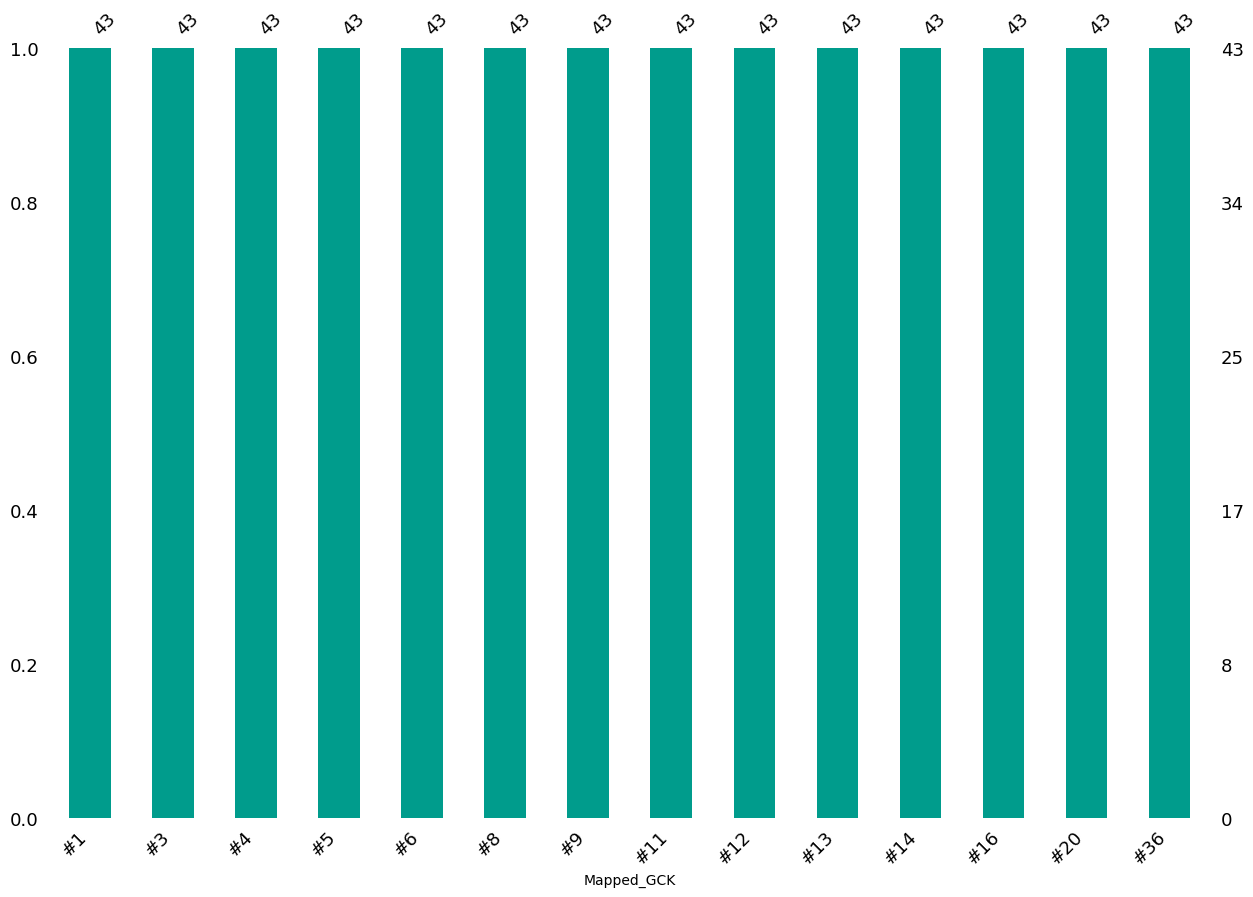

In [121]:
msno.bar(new_monthly_sales, figsize=(15,10), fontsize=13, 
         color=f.main_color, sort="ascending")

### Market Data

In [122]:
market_data.isna().sum()

CHI Production Index                0
CHI Shipments Index                 0
FRA Production Index                0
FRA Shipments Index                 0
GER Production Index                0
GER Shipments Index                 0
ITA Production Index                0
ITA Shipments Index                 0
JAP Production Index                0
JAP Shipments Index                 0
SWI Production Index                1
SWI Shipments Index                 1
UK Production Index                 0
UK Shipments Index                 18
USA Production Index                0
USA Shipments Index                 1
Europe Production Index             0
Europe Shipments Index              0
(W) Price of Base Metals            0
(W) Price of Energy                 0
(W) Price of Metals & Minerals      0
(W) Price of Natural gas index      0
(W) Price of Crude oil, average     0
(W) Price of Copper                 0
USA EUR to LCU Conversion Rate      0
USA EE Producer Prices              0
UK EE Produc

In [123]:
f.missing_value_summary(market_data)

Unique Values  NaN Values  Percentage NaN
SWI Production Index                       218           1            0.46
SWI Shipments Index                        218           1            0.46
UK Shipments Index                         201          18            8.22
USA Shipments Index                        218           1            0.46
UK EE Producer Prices                      131          18            8.22
FRA EE Producer Prices                      79          35           15.98
CHI EE Producer Prices                     196          23           10.50
SWI Machinery & Equipment Index            202           1            0.46
(W) EE Production Index                    208          11            5.02
SWI EE Production Index                    201           1            0.46

<br>

`Missingno` Bar Plot

<Axes: >

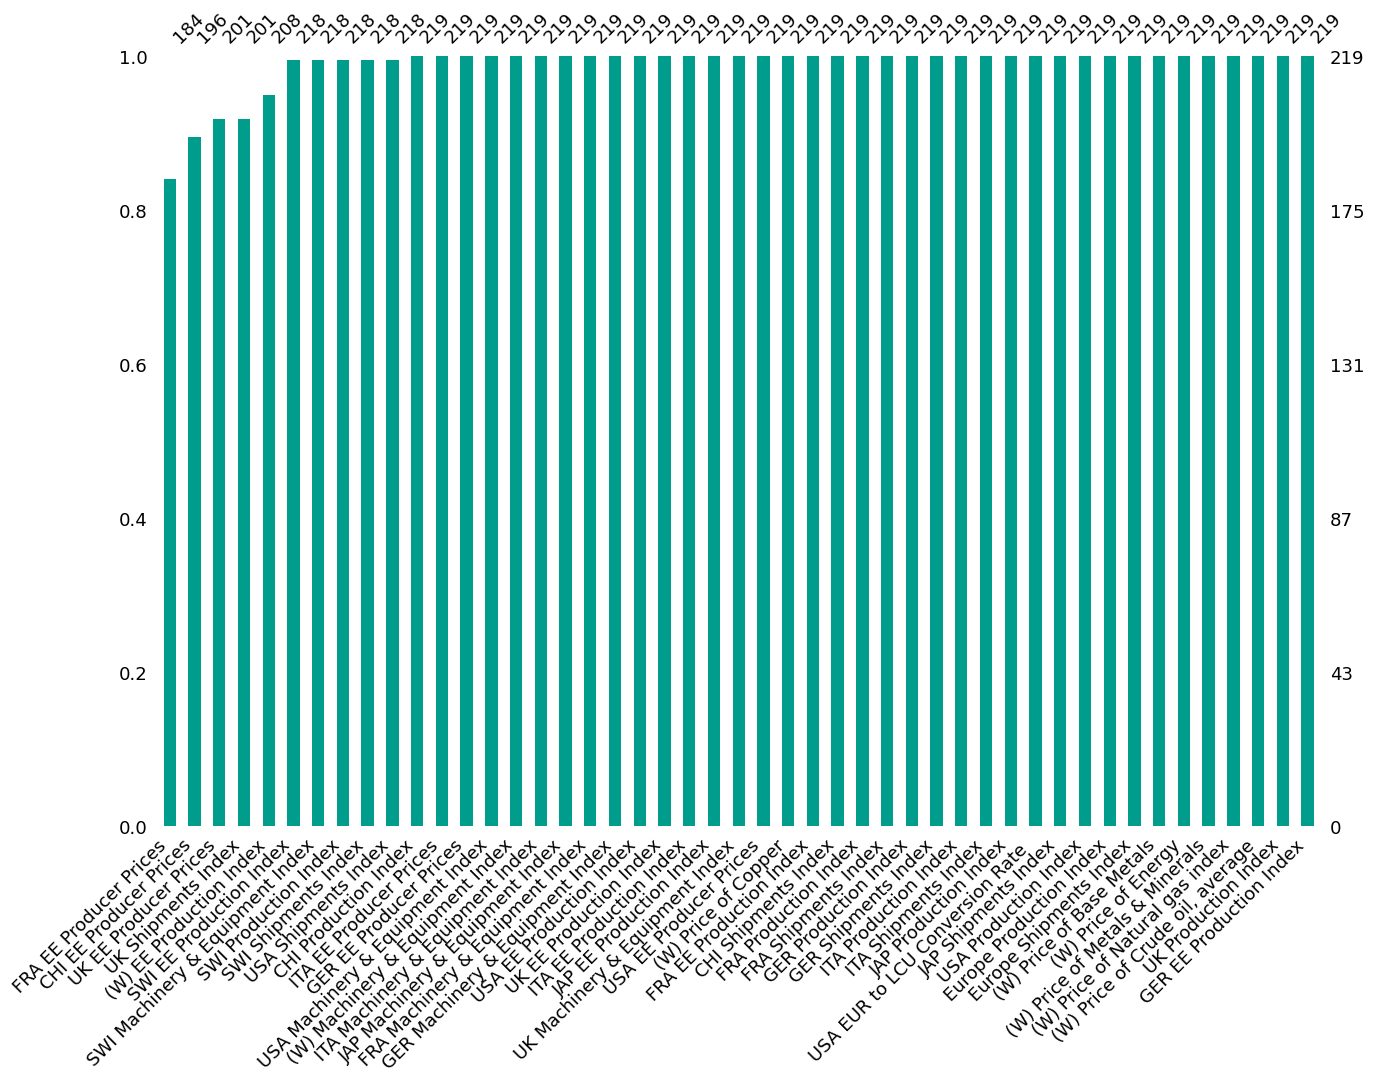

In [124]:
msno.bar(market_data, figsize=(15,10), fontsize=13, 
                 color=f.main_color, sort="ascending")

**Filling Missing values**

<div class="alert-warning">
    
work in progress

In [125]:
# market_data_resampled.interpolate(method='cubic', inplace=True)

NameError: name 'market_data_resampled' is not defined

Creating a Pipeline to easily manage Scaling and Imputation

In [126]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', KNNImputer(n_neighbors=10))
])

Imputation

In [127]:
market_data2 = market_data.copy()

# Fit Transform
scaled_and_imputed_data = pipeline.fit_transform(market_data2)

In [128]:
imputed_data = pipeline.named_steps['scaler'].inverse_transform(scaled_and_imputed_data)

market_data2 = pd.DataFrame(imputed_data, 
                            columns=market_data.columns, 
                            index=market_data.index)

**See how imputed values compare with real values**

Allows to visually compare different scalers and different number of neighbours

In [129]:
def plot_imputation(df_with_missing, df_no_missing, cols_with_missing):

    for var in cols_with_missing:
        plt.figure(figsize=(14, 6))

        # Plot the full continuous line — including both original and imputed values
        plt.plot(df_no_missing.index, df_no_missing[var], 
                 color=f.main_color, 
                 label='Line (with imputed values)', zorder=3)

        # Highlight the imputed points on top of that line
        missing_idx = df_with_missing[var].isna()
        plt.scatter(df_no_missing.index[missing_idx],
                    df_no_missing.loc[missing_idx, var],
                    color='red', label='Imputed Points', zorder=4, marker='x', s=70)

        plt.xlabel('Time')
        plt.ylabel(var)
        plt.legend()
        plt.title(f'Original vs Imputed Values Over Time for \"{var}\" (Continuous Line)')
        plt.grid(True)
        plt.show()


In [130]:
cols_with_missing = market_data.columns[market_data.isna().any()]

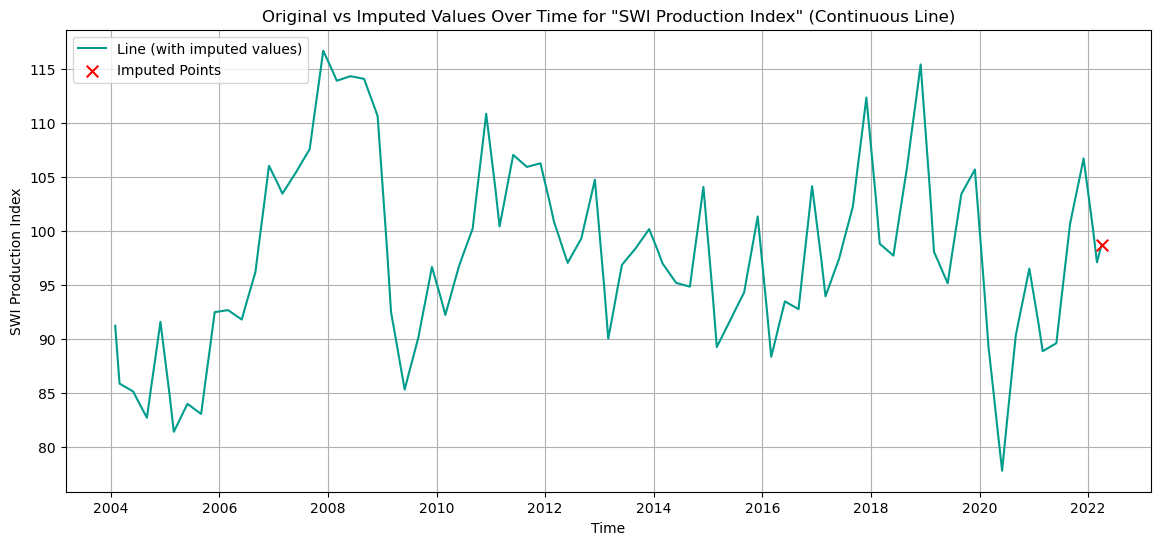

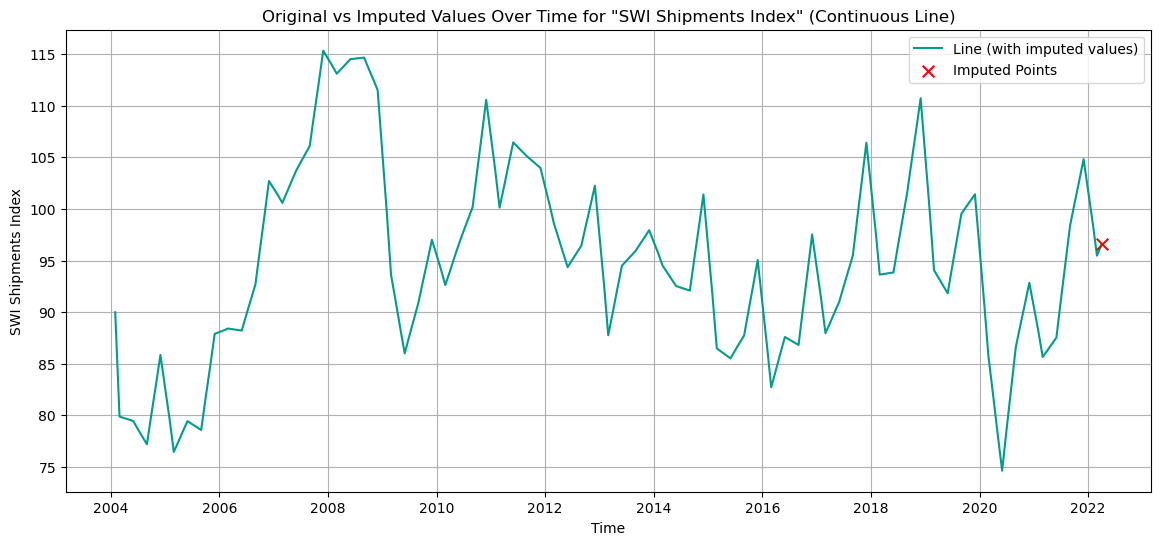

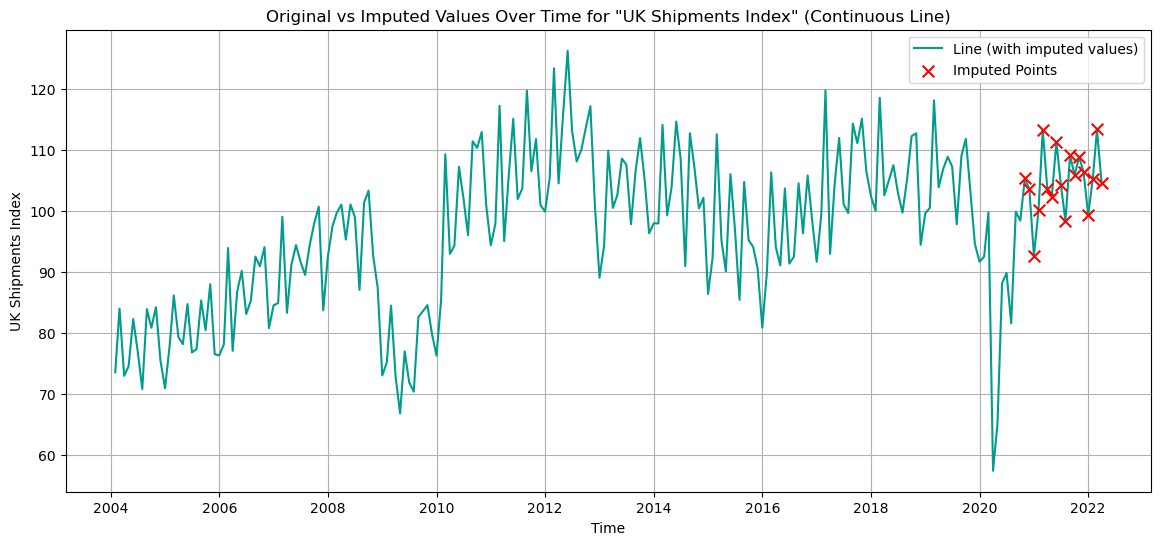

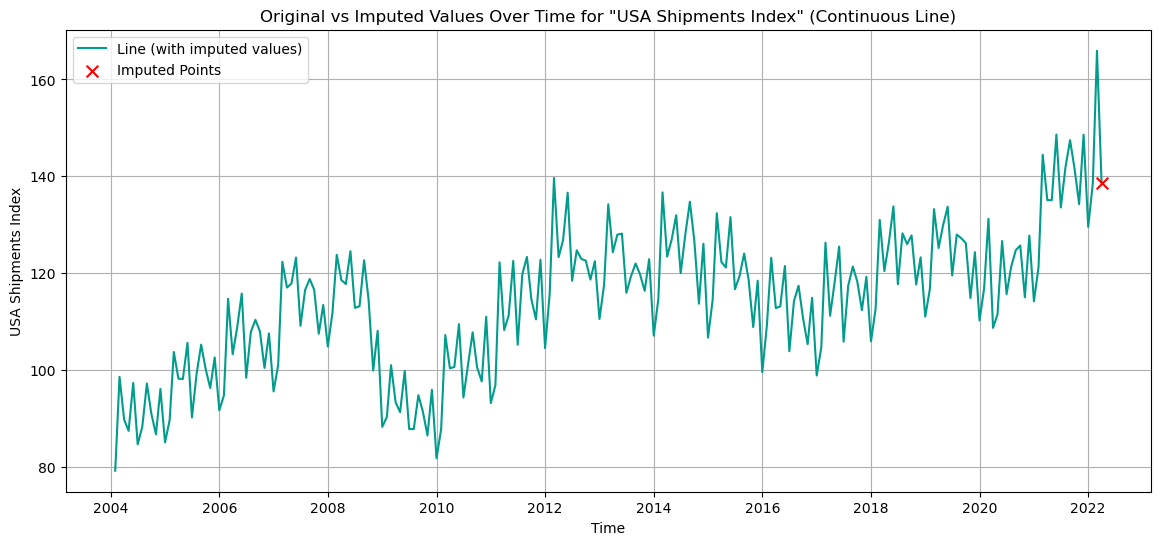

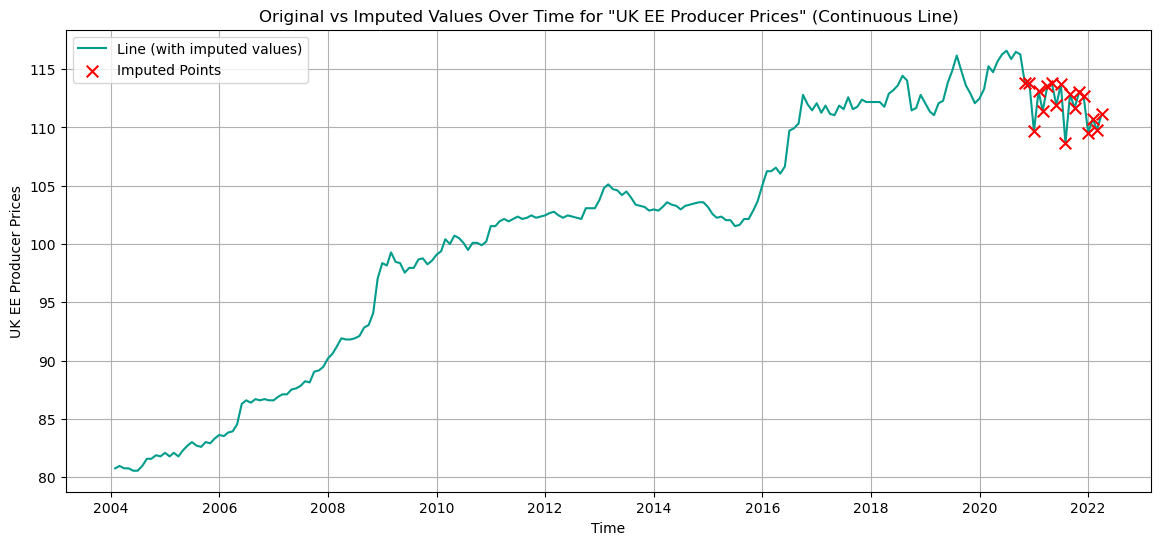

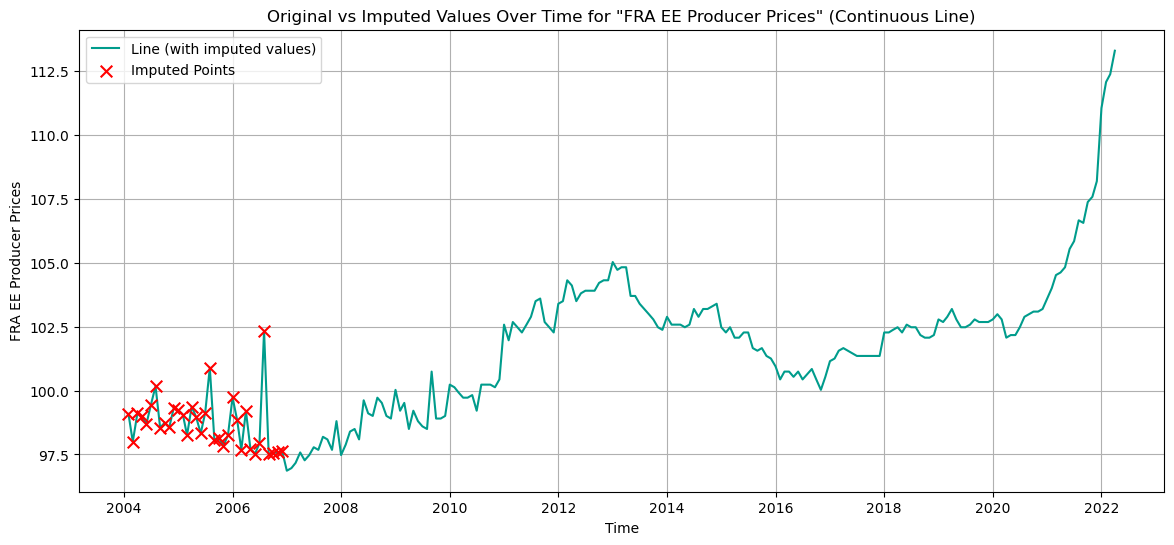

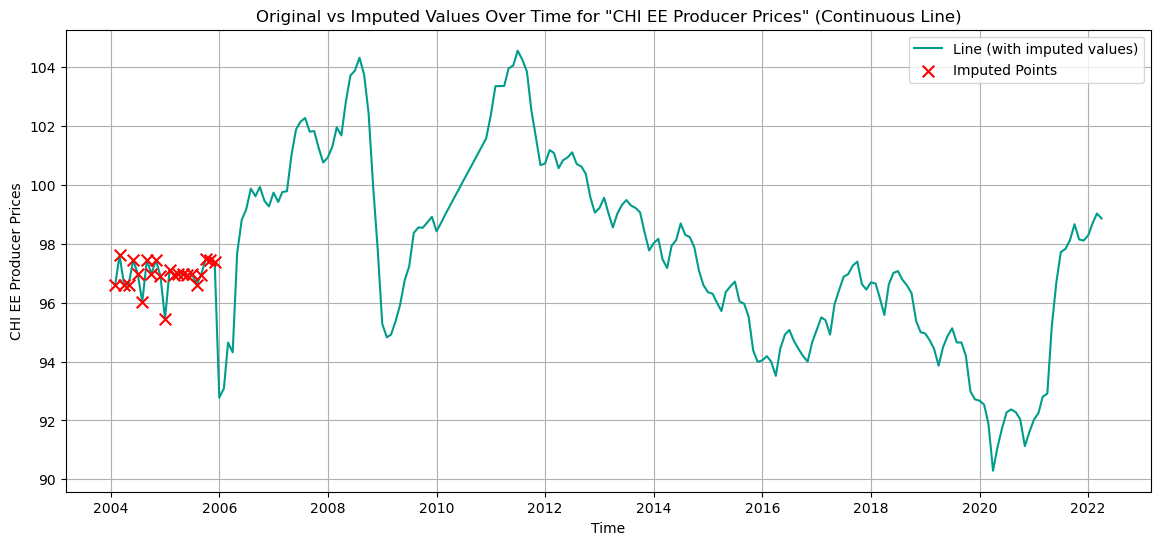

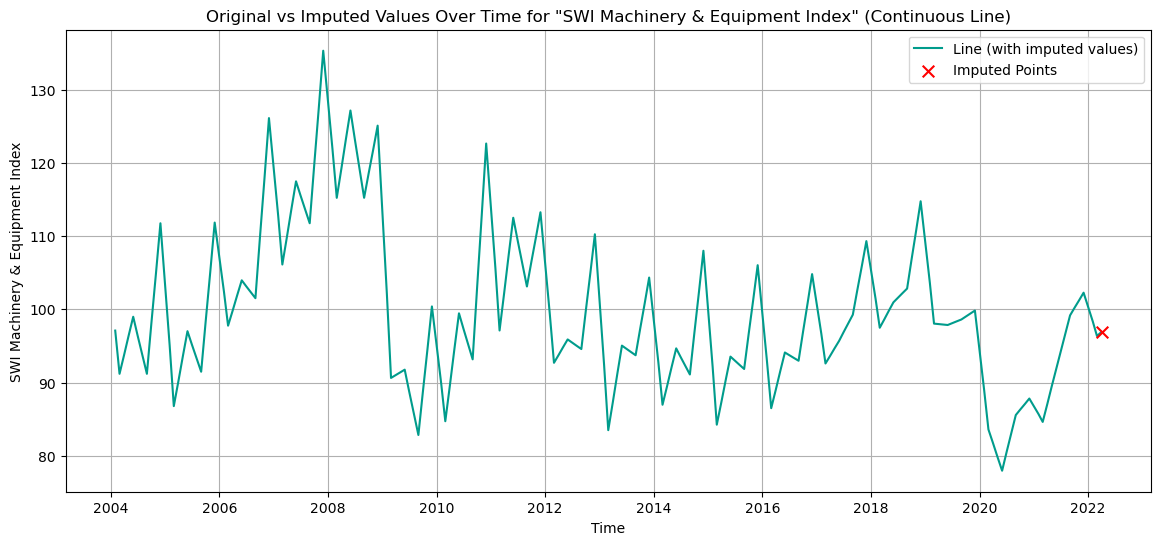

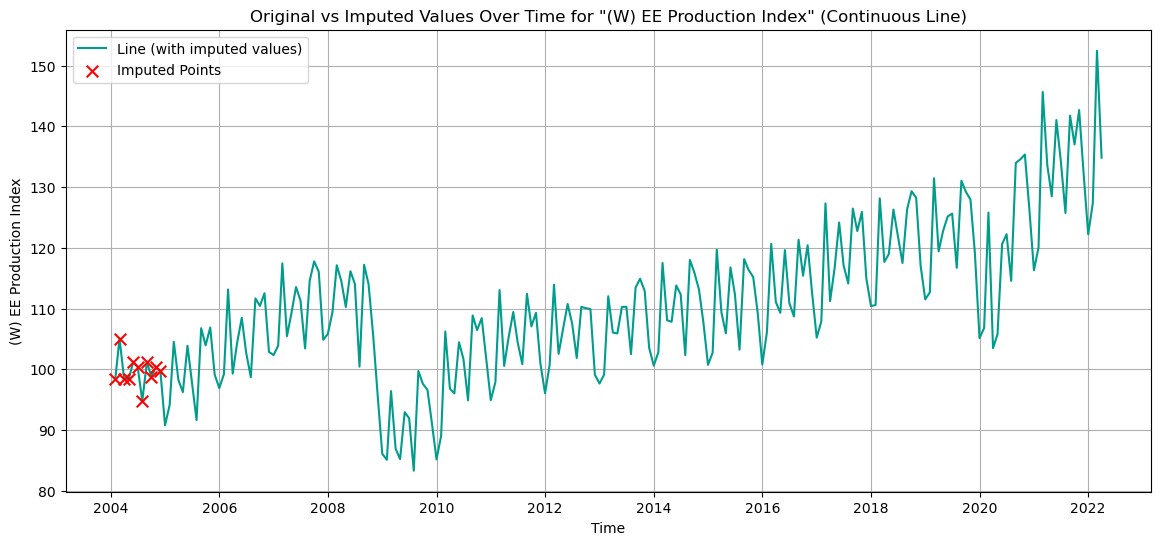

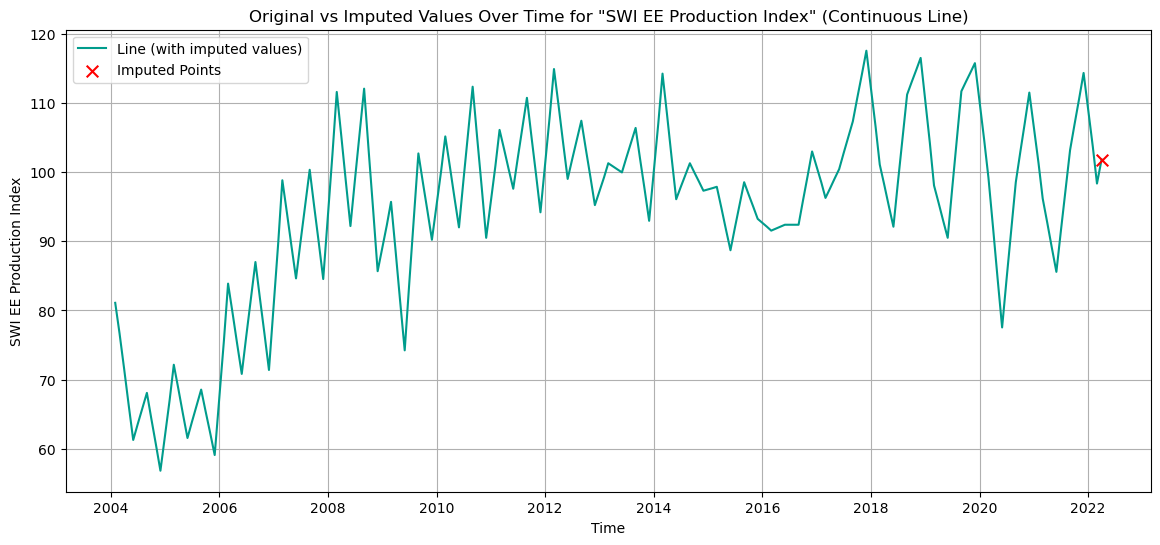

In [131]:
plot_imputation(market_data, market_data2, cols_with_missing)

In [132]:
plot_imputation(market_data, market_data_resampled, cols_with_missing)

NameError: name 'market_data_resampled' is not defined

## 5.3 Statistical Tests

<a href="#top">Top &#129033;</a>

### Sales Data

**Augmented Dickey-Fuller Test for Stationarity**


Used to determine if a time series is stationary or if it has a unit root (non-stationary). Stationarity means that the statistical properties of the time series, such as the mean, variance, and autocorrelation, do not change over time.

- If the p-value is below a chosen significance level (0.05), reject the null hypothesis, and conclude the series is stationary.
- If the p-value is above the significance level, fail to reject the null hypothesis, and conclude the series is non-stationary.

In [133]:
st.adf_test(new_monthly_sales, new_monthly_sales.columns)

ADF Statistic p-value                              Critical Values  \
#1          -6.00    0.00  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#3          -6.59    0.00  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#4          -5.32    0.00  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#5          -7.64    0.00  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#6          -3.48    0.01  {'1%': -3.601, '5%': -2.935, '10%': -2.606}   
#8           2.34    1.00  {'1%': -3.627, '5%': -2.946, '10%': -2.612}   
#9          -7.01    0.00  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#11         -5.58    0.00  {'1%': -3.601, '5%': -2.935, '10%': -2.606}   
#12         -3.87    0.00  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#13         -3.25    0.02  {'1%': -3.606, '5%': -2.937, '10%': -2.607}   
#14         -6.87    0.00  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   
#16         -6.37    0.00  {'1%': -3.646, '5%': -2.954, '10%': -2.616}   
#20         -3.13    0.02  {'1%': -3.601, '5%': -2.935, '10%': -2.606}   
#36         -7.00    0.00  {'1%': -3.597, '5%': -2.933, '10%': -2.605}   

    Stationary  
#1         Yes  
#3         Yes  
#4         Yes  
#5         Yes  
#6         Yes  
#8          No  
#9         Yes  
#11        Yes  
#12        Yes  
#13        Yes  
#14        Yes  
#16        Yes  
#20        Yes  
#36        Yes

#8 is non-stationary --> try differencing

In [134]:
new_monthly_sales['diff_#8'] = new_monthly_sales['#8'].diff().fillna(method='bfill')

# fill c/ 0 fica bue diferente do resto dos numeros
# fill com ffill mantém 1 Nan

In [135]:
st.adf_test(new_monthly_sales, ['diff_#8'])

ADF Statistic p-value                             Critical Values  \
diff_#8         -4.86    0.00  {'1%': -3.621, '5%': -2.944, '10%': -2.61}   

        Stationary  
diff_#8        Yes

**Seasonality Decomposition - STL**

In [136]:
cols = ['#1']
st.stl_decomposition(new_monthly_sales, cols)

## 5.4 Feature Engineering

<a href="#top">Top &#129033;</a>

### Sales Data

**Time Related Features**

In [137]:
# Extract Year and Month from DateTimeIndex
new_monthly_sales['Year'] = new_monthly_sales.index.year
new_monthly_sales['Month'] = new_monthly_sales.index.month

In [138]:
# Create Semester and Quarter columns
new_monthly_sales['Semester'] = new_monthly_sales['Month'].apply(f.get_semester)
new_monthly_sales['Quarter'] = new_monthly_sales['Month'].apply(f.get_quarter)

In [139]:
# Create a cyclical feature for Month
new_monthly_sales['sin_month'] = np.sin(2 * np.pi * new_monthly_sales['Month'] / 12)
new_monthly_sales['cos_month'] = np.cos(2 * np.pi * new_monthly_sales['Month'] / 12)

In [140]:
# Apply the function to get both weekend days and total days in the month
new_monthly_sales[['WeekendDaysCount', 'TotalDaysInMonth']] = new_monthly_sales.apply(
    lambda row: pd.Series(f.count_weekends_in_month(int(row['Year']), int(row['Month']))), axis=1)

# Calculate the percentage of weekend days in the month
new_monthly_sales['WeekendDaysPercentage'] = (new_monthly_sales['WeekendDaysCount'] / new_monthly_sales['TotalDaysInMonth']) * 100

In [141]:
new_monthly_sales['SundayCount'] = new_monthly_sales.apply(lambda row: f.count_sundays_in_month(int(row['Year']), int(row['Month'])), axis=1)

In [142]:
new_monthly_sales['GerHolidayCount'] = new_monthly_sales.apply(lambda row: f.count_holidays_in_month(new_monthly_sales, int(row['Year']), int(row['Month'])), axis=1)

**Lag Features**

In [143]:
# Depends on the ACF and PACF
lag_dict = {
    "#1": [1],
    "#3": [1],
    "#4": [1, 6],
    "#5": [1],
    "#6": [1],
    "#8": [1, 3],
    "#9": [1, 12],
    "#11": [1],
    "#12": [1, 3, 12],
    "#13": [1, 3],
    "#14": [1, 6],
    "#16": [1, 3],
    "#20": [1],
    "#36": [1,12]
}

# Lags are created for each product, and rows with missing lag values are removed.
new_monthly_sales = f.create_lag_features(new_monthly_sales, lag_dict)


| Scenario                        | How to Read ACF                                | How to Read PACF                           | What Lags to Use                       |
|----------------------------------|------------------------------------------------|--------------------------------------------|----------------------------------------|
| Short-term dependency            | ACF quickly drops                              | PACF has a strong spike at lag 1           | Use Sales_Lag_1                        |
| Quarterly patterns (every 3 months) | ACF has peaks at lags 3, 6, 9                  | PACF spikes at lag 3                       | Use Sales_Lag_3, Sales_Lag_6           |
| Yearly seasonality (12 months)   | ACF has a peak at lag 12                       | PACF has a spike at lag 12                 | Use Sales_Lag_12                       |
| Gradual decline in ACF           | ACF slowly decreases                           | PACF has multiple spikes                   | Use Sales_Lag_1, Sales_Lag_3, Sales_Lag_12 |


**Rolling Mean**

In [144]:
# Depends on the ACF and PACF
rolling_dict  = {
    "#4": [6],
    "#8": [3],
    "#9": [12],
    "#12": [3, 12],
    "#13": [3],
    "#14": [6],
    "#16": [3],
    "#36": [12]
}


new_monthly_sales = f.create_rolling_mean_features(new_monthly_sales, rolling_dict)

### Market Data

**Rolling Mean**

In [145]:
for col in market_data2.columns:
    col_name = f'{col}_Rolling_Mean_3'
    market_data2[col_name] = market_data2[col].rolling(window=3).mean()
    market_data2[col_name].fillna(method='bfill', inplace=True)
    

In [146]:
market_data2

CHI Production Index  CHI Shipments Index  FRA Production Index  \
Date                                                                          
2004-02-01                 16.94                16.94                112.09   
2004-03-01                 23.71                23.71                136.33   
2004-04-01                 24.44                24.44                117.79   
2004-05-01                 23.71                23.71                109.00   
2004-06-01                 27.01                27.01                133.79   
...                          ...                  ...                   ...   
2021-12-01                310.76               310.76                100.57   
2022-01-01                235.96               235.96                 85.74   
2022-02-01                235.96               235.96                 90.60   
2022-03-01                329.41               329.41                107.84   
2022-04-01                267.37               267.37                 87.70   

            FRA Shipments Index  GER Production Index  GER Shipments Index  \
Date                                                                         
2004-02-01                83.46                 82.62                79.45   
2004-03-01               106.17                100.56                97.01   
2004-04-01                92.01                 89.65                84.93   
2004-05-01                85.70                 86.88                82.37   
2004-06-01               106.64                 99.01                95.11   
...                         ...                   ...                  ...   
2021-12-01               134.59                118.10               149.36   
2022-01-01               108.16                 94.55               120.35   
2022-02-01               117.72                103.99               129.38   
2022-03-01               136.86                121.31               151.20   
2022-04-01               116.53                 99.52               127.02   

            ITA Production Index  ITA Shipments Index  JAP Production Index  \
Date                                                                          
2004-02-01                124.29                86.56                109.33   
2004-03-01                143.41               106.34                140.88   
2004-04-01                129.08                95.58                105.85   
2004-05-01                135.59               100.09                101.86   
2004-06-01                136.42               110.89                120.33   
...                          ...                  ...                   ...   
2021-12-01                 94.01               150.48                127.77   
2022-01-01                 86.85               101.26                110.46   
2022-02-01                106.58               120.96                117.88   
2022-03-01                124.64               153.65                152.00   
2022-04-01                103.56               128.73                114.26   

            JAP Shipments Index  SWI Production Index  SWI Shipments Index  \
Date                                                                         
2004-02-01               110.50                 91.22                89.99   
2004-03-01               144.69                 85.87                79.88   
2004-04-01               102.66                 85.62                79.74   
2004-05-01               100.31                 85.38                79.60   
2004-06-01               119.62                 85.13                79.46   
...                         ...                   ...                  ...   
2021-12-01               131.03                106.70               104.82   
2022-01-01               110.82                103.50               101.70   
2022-02-01               118.30                100.29                98.58   
2022-03-01               156.40                 97.09                95.47   
2022-

## 5.5 Outliers

<a href="#top">Top &#129033;</a>

### Sales Data

**ADF, Autocorrelation and Partial Autocorrelation**

Useful to visually identify outliers

Results for #1: | ADF Statistic: -6.002443 | p-value: 0.000000


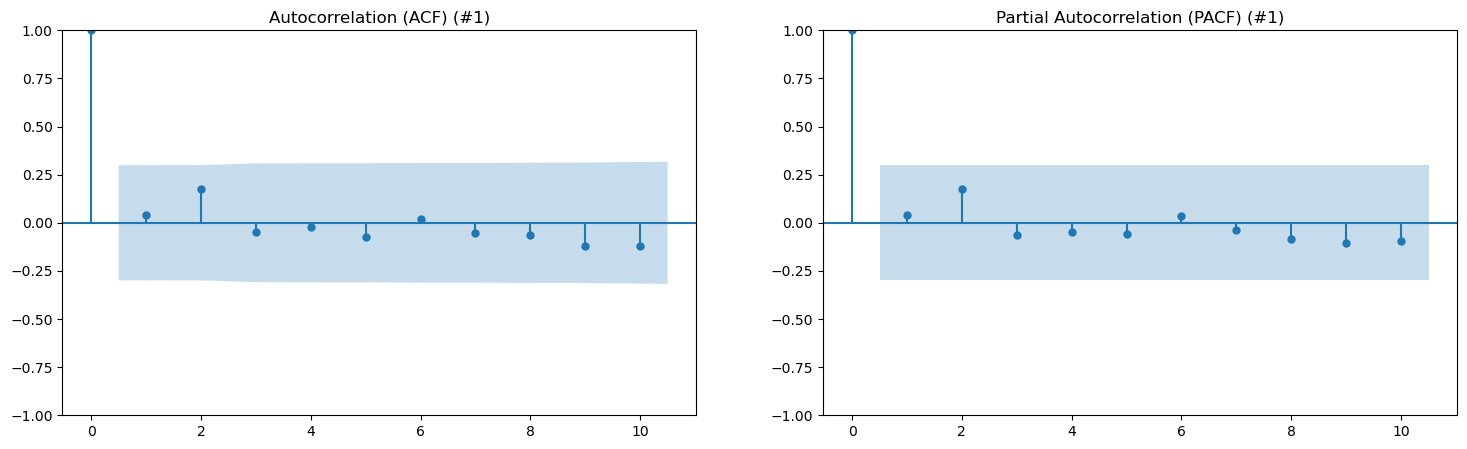

Results for #3: | ADF Statistic: -6.590291 | p-value: 0.000000


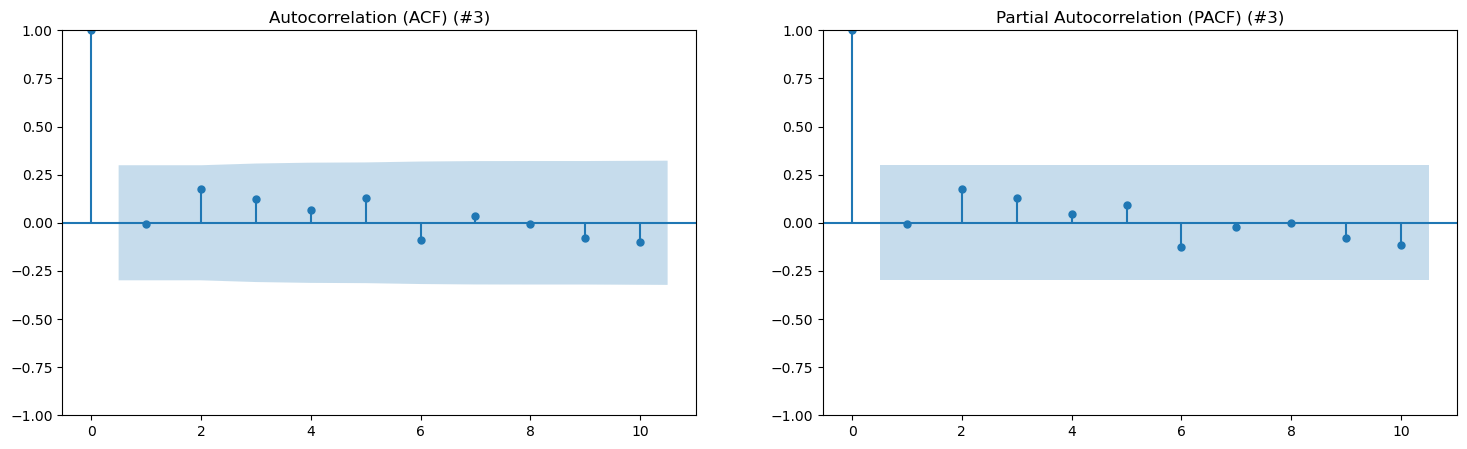

Results for #4: | ADF Statistic: -5.319293 | p-value: 0.000005


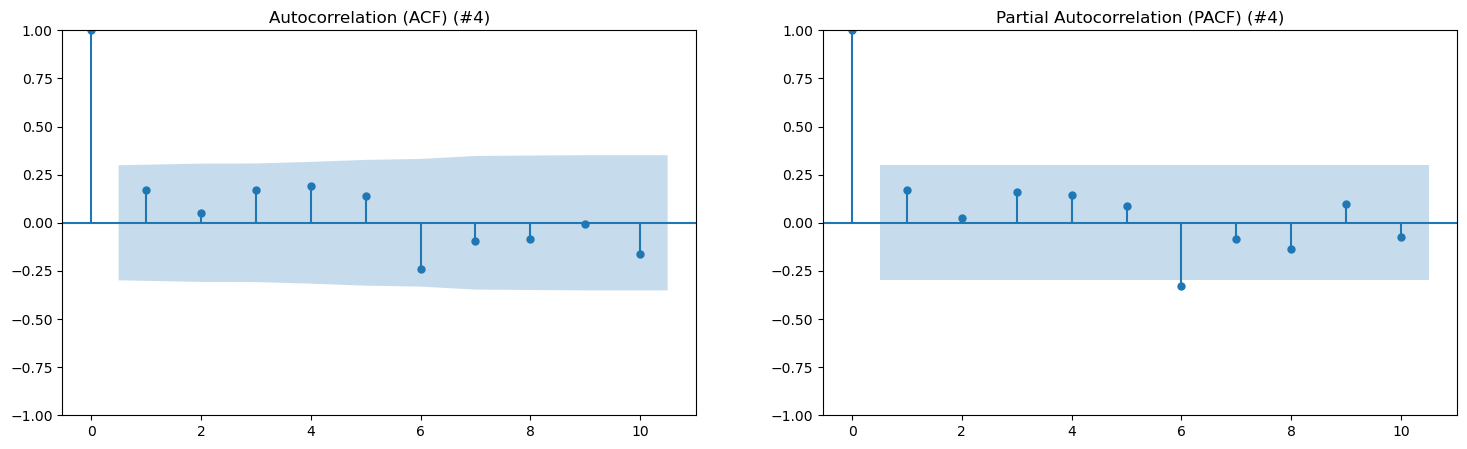

Results for #5: | ADF Statistic: -7.636228 | p-value: 0.000000


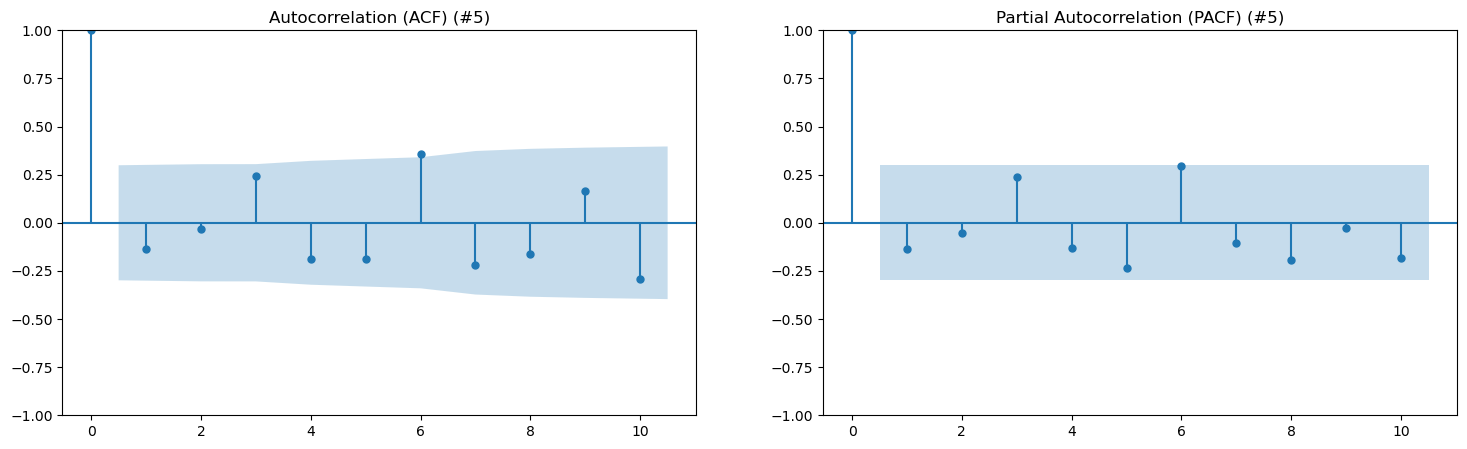

Results for #6: | ADF Statistic: -3.477762 | p-value: 0.008577


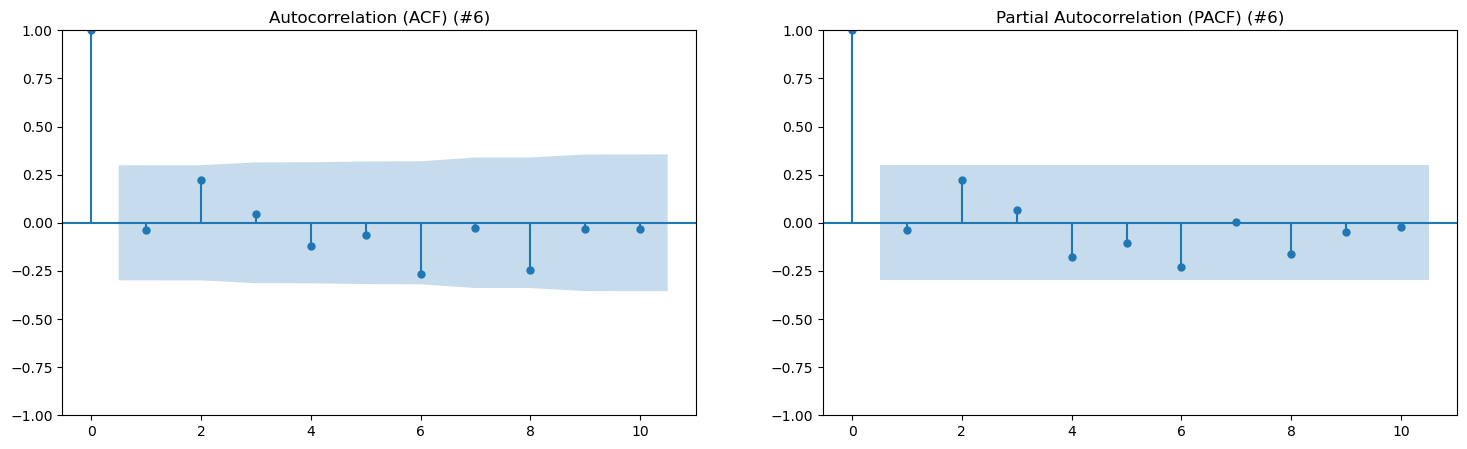

Results for #8: | ADF Statistic: 2.340859 | p-value: 0.998980


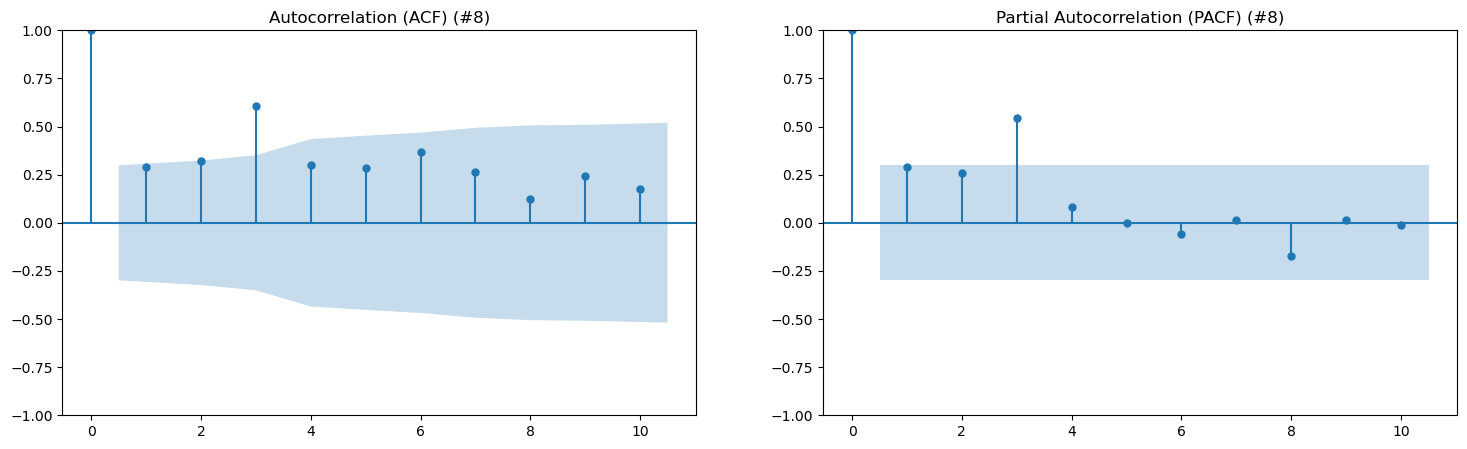

Results for #9: | ADF Statistic: -7.013494 | p-value: 0.000000


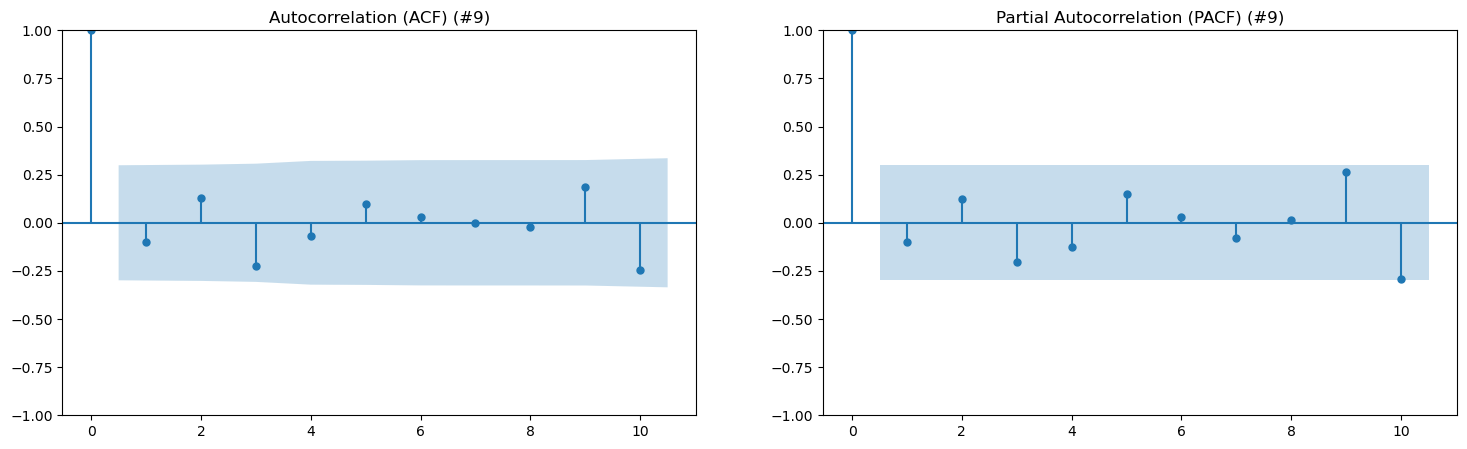

Results for #11: | ADF Statistic: -5.577923 | p-value: 0.000001


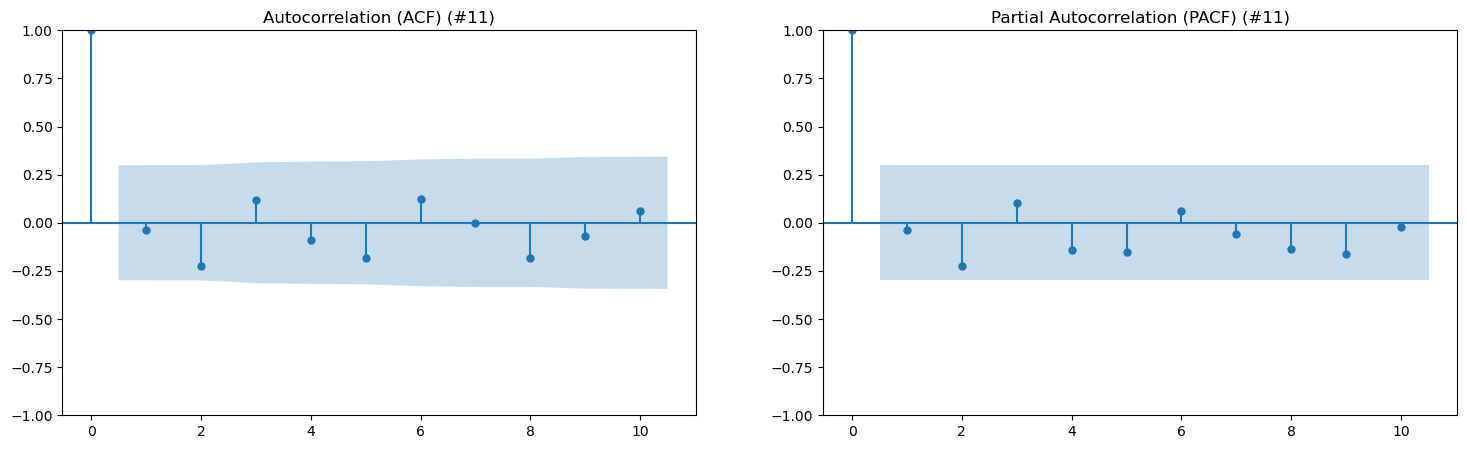

Results for #12: | ADF Statistic: -3.869337 | p-value: 0.002272


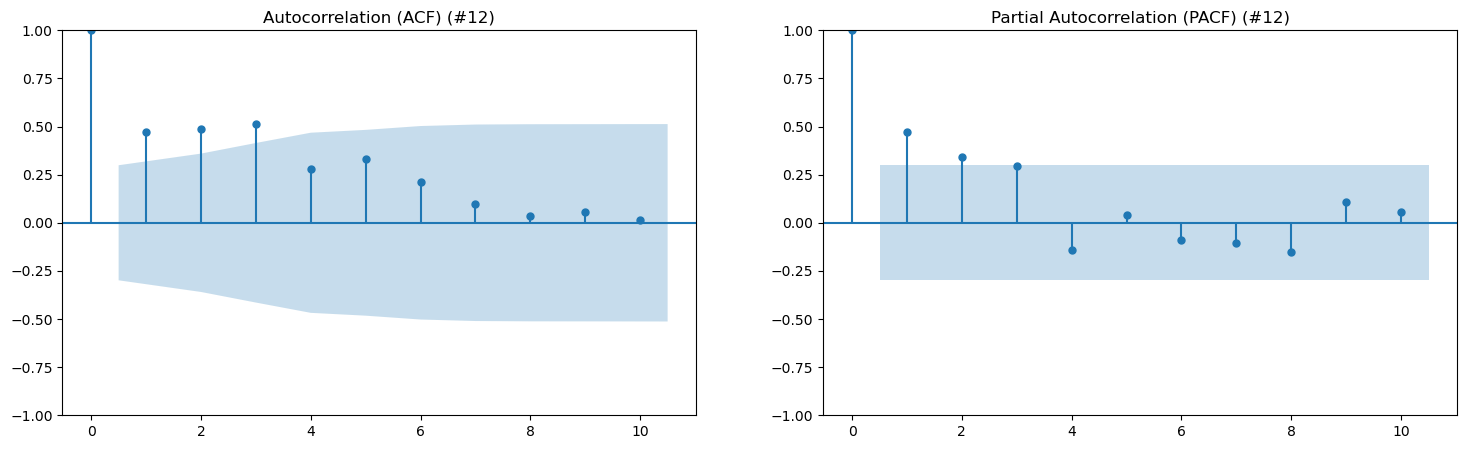

Results for #13: | ADF Statistic: -3.254199 | p-value: 0.017054


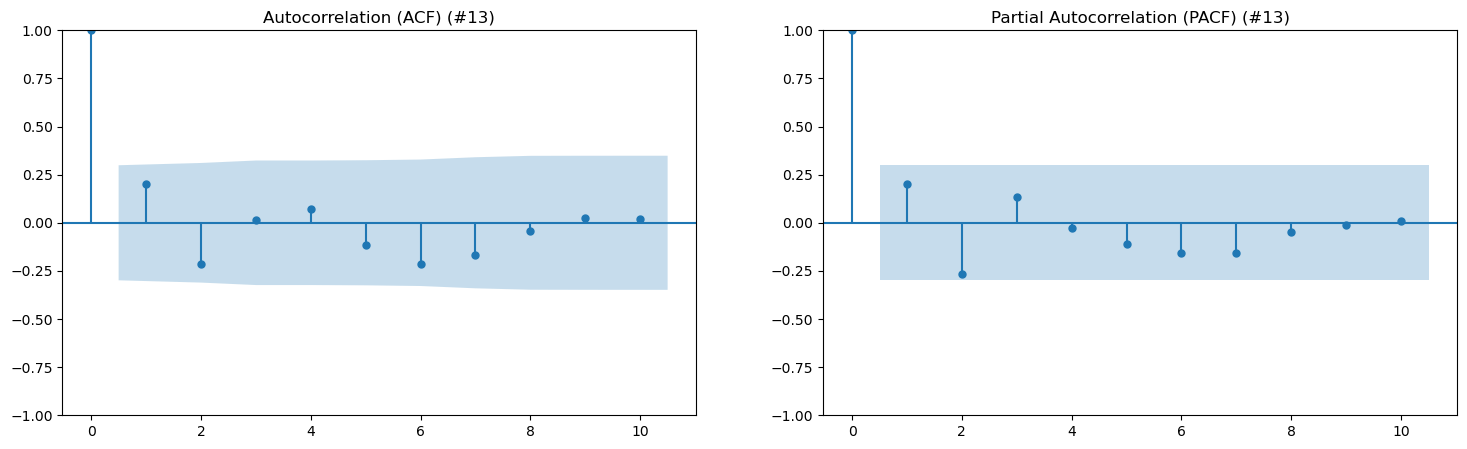

Results for #14: | ADF Statistic: -6.871822 | p-value: 0.000000


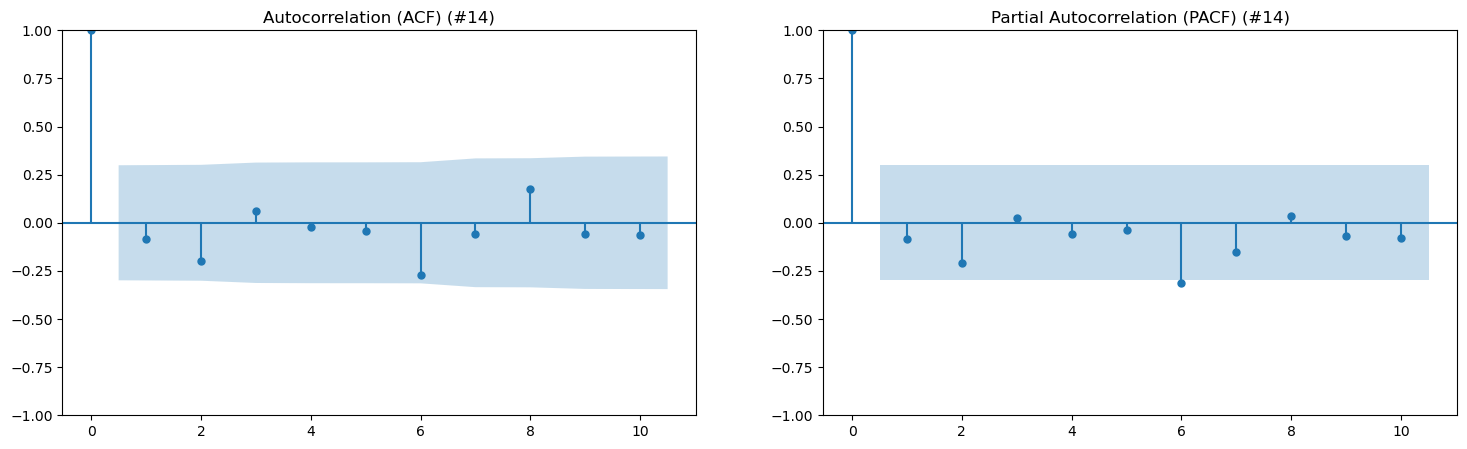

Results for #16: | ADF Statistic: -6.367204 | p-value: 0.000000


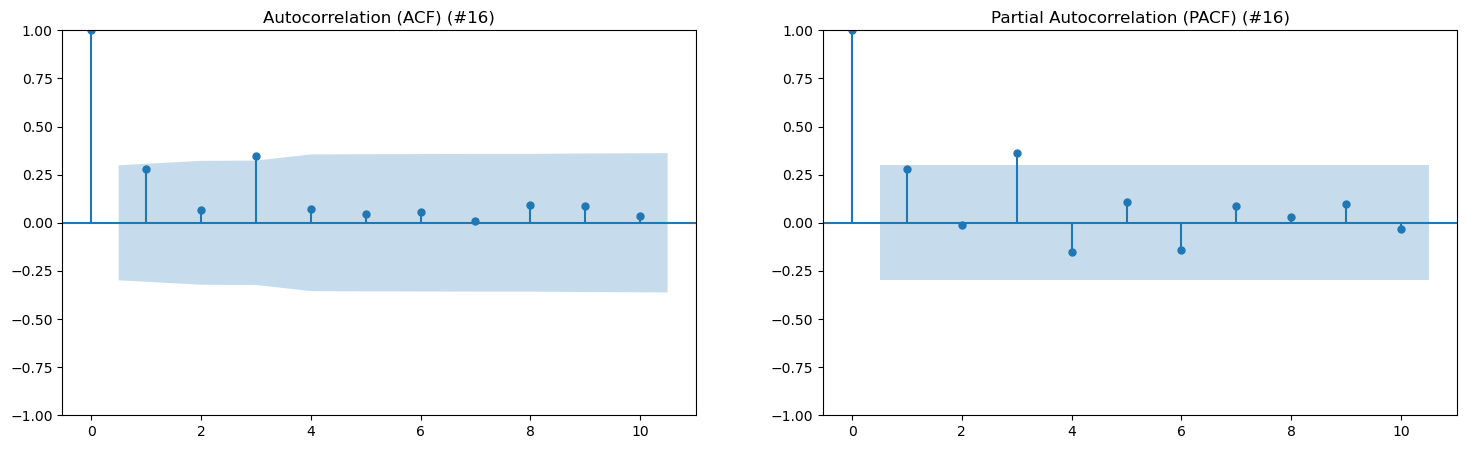

Results for #20: | ADF Statistic: -3.125179 | p-value: 0.024745


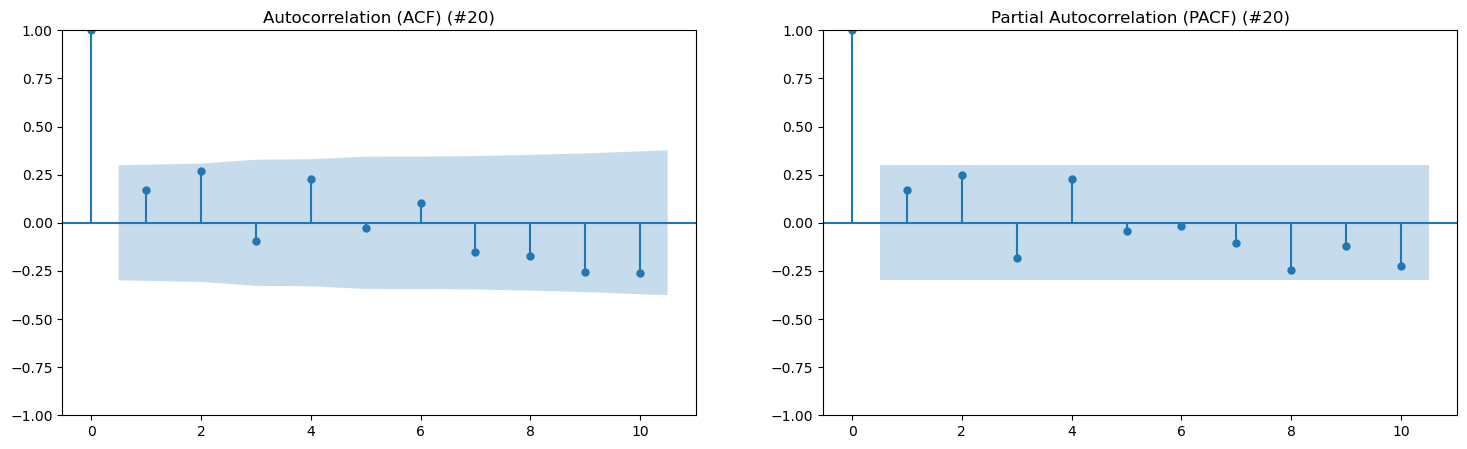

Results for #36: | ADF Statistic: -7.000027 | p-value: 0.000000


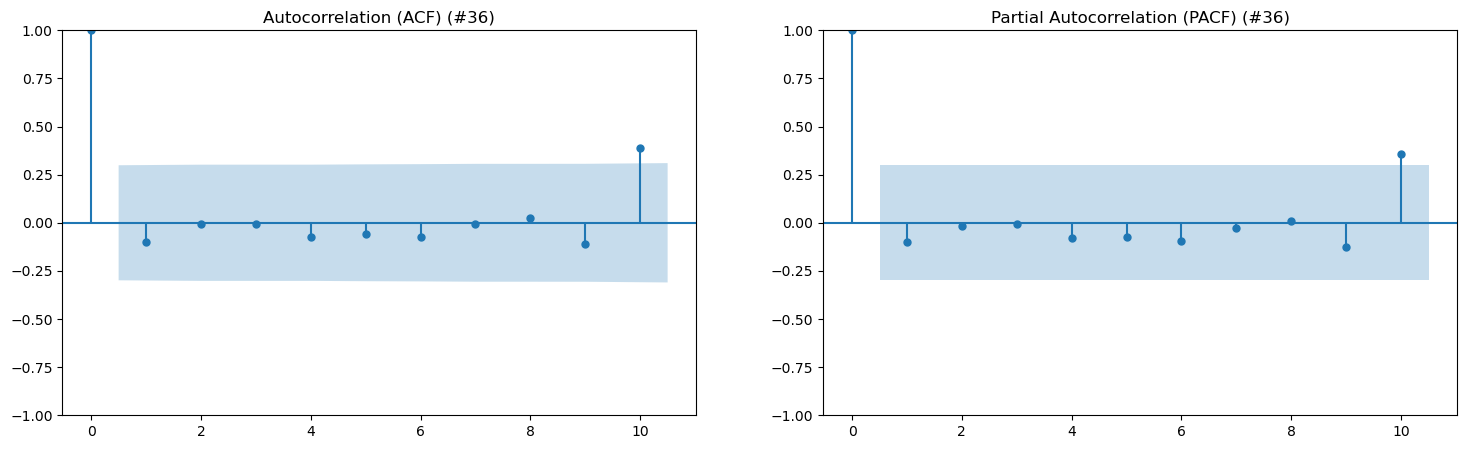

Results for diff_#8: | ADF Statistic: -4.856417 | p-value: 0.000042


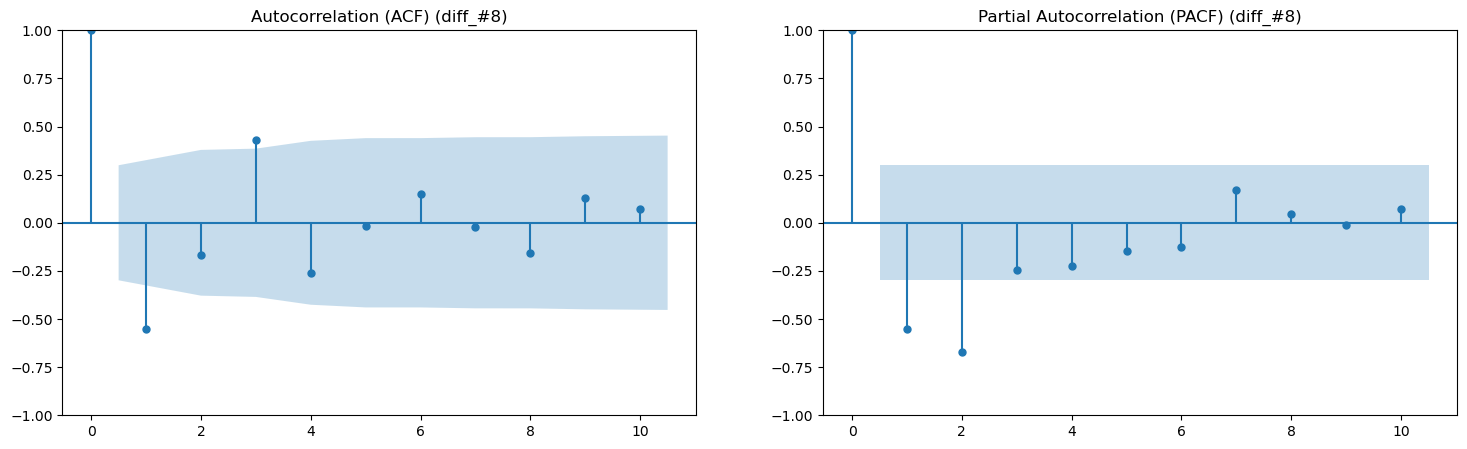

Results for Year: | ADF Statistic: -0.970959 | p-value: 0.763709


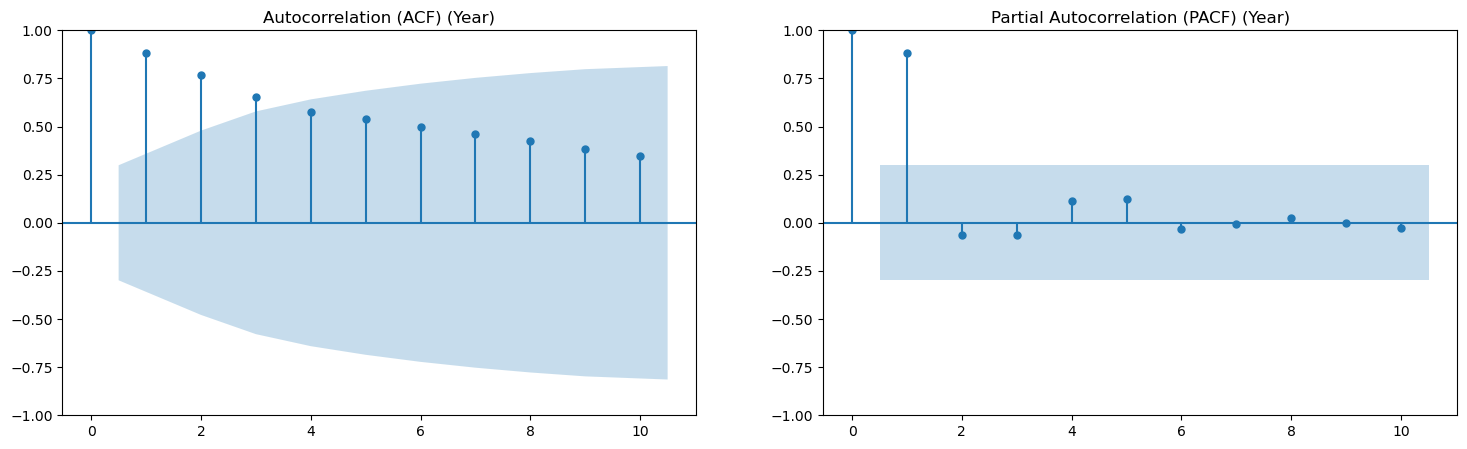

Results for Month: | ADF Statistic: -108463050309595.125000 | p-value: 0.000000


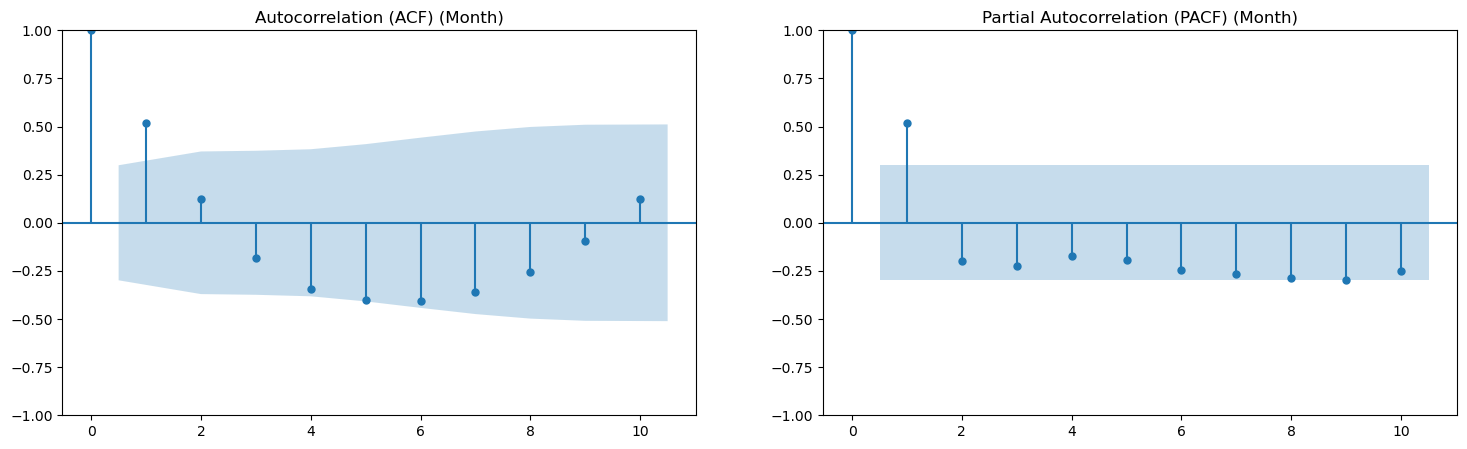

Results for Semester: | ADF Statistic: -5170473275635226.000000 | p-value: 0.000000


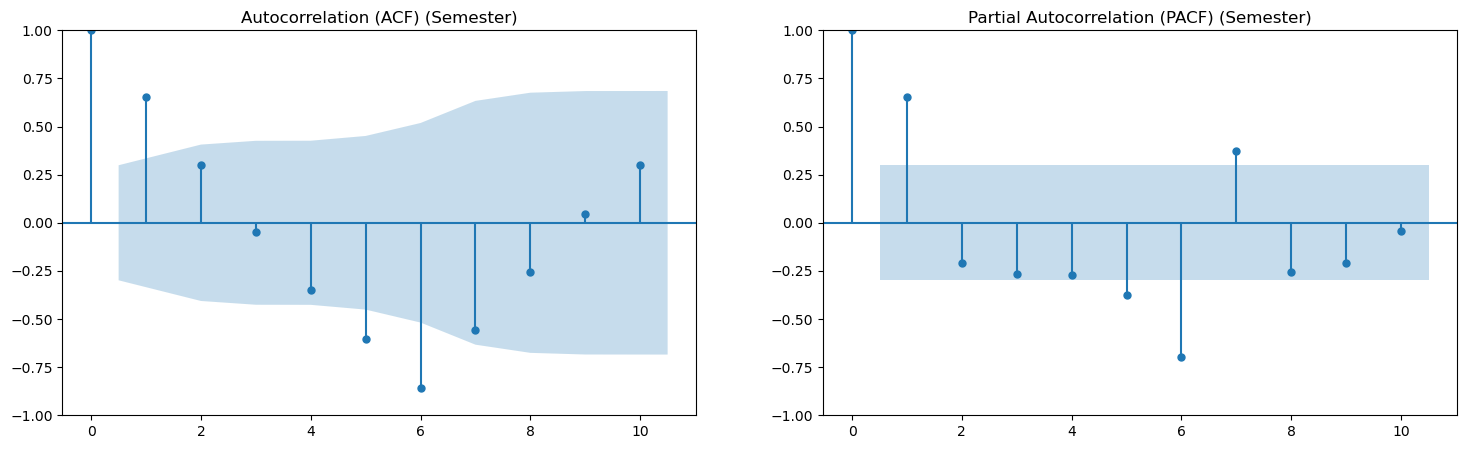

ValueError: could not convert string to float: 'Q4'

In [147]:
st.outliers_stationarity(new_monthly_sales)

| Column | Outliers |
| ------ | -------- |
| #1 | 2018-11 |
| #3 | 2021-01 |
| #4 | - |
| #5 | 2021-01, 2021-08 |
| #6 | - |
| #8 | - |
| #8_diff | - |
| #9 | 2020-10, 2020-11 |
| #11 | - |
| #12 | - |
| #13 | - |
| #14 | 2021-07 |
| #16 | 2018-12, 2019-3 |
| #20 | - |
| #36 | 2020-06, 2021-04 |




**Boxplots**

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[0], 
                              n_bins=30,
                             out_left = 20000000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[1], 
                              n_bins=30,
                              out_left = 6000000,
                              out_right = 18000000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[2], 
                              n_bins=30,
                              out_right = 750000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[3], 
                              n_bins=30,
                              out_left = 2000000,
                              out_right = 18000000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[4], 
                              n_bins=30)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[5], 
                              n_bins=30,
                              out_right = 2200000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[6], 
                              n_bins=30,
                              out_right = 21000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[7], 
                              n_bins=30)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[8], 
                              n_bins=30)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[9], 
                              n_bins=30,
                              out_right = 60000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[10], 
                              n_bins=30,
                              out_right = 40000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[11], 
                              n_bins=30,
                              out_right = 600000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[12], 
                              n_bins=30,
                              out_right = 6100)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[13], 
                              n_bins=30,
                              out_right = 100000)

In [ ]:
plot_distribution_and_boxplot(new_monthly_sales, 
                              new_monthly_sales.columns[14], 
                              n_bins=30,
                              out_left = -1100000,
                              out_right = 1100000)

**Treating Outliers**

<div class="alert-danger">
    
NEED TO DECIDE

# 6. Extra Data

<a href="#top">Top &#129033;</a>

In [148]:
# Find the start date of the new_monthly_sales dataset
start_date = new_monthly_sales.index.min()

# Filter market_data to match the start date of new_monthly_sales
market_data_filtered = market_data[market_data.index >= start_date]

**Import Extra Data**

In [ ]:
stocks = pd.read_csv('./extra data/clean_stock_data.csv', index_col = 'Date')
consumer_conf = pd.read_csv('./extra data/clean_consumer_confidence.csv', index_col = 'TIME_PERIOD')
business_conf = pd.read_csv('./extra data/clean_business_confidence.csv', index_col = 'TIME_PERIOD')

**Rename Columns**

In [ ]:
stocks = stocks.rename(columns=u.rename_dict_stocks)
consumer_conf = consumer_conf.rename(columns=u.rename_dict_consumer)
business_conf = business_conf.rename(columns=u.rename_dict_business)

**Ensure same index datatype**

In [ ]:
market_data_filtered.index = pd.to_datetime(market_data_filtered.index)
consumer_conf.index = pd.to_datetime(consumer_conf.index)
business_conf.index = pd.to_datetime(business_conf.index)
stocks.index = pd.to_datetime(stocks.index)

**Join Extra Data to Market Data**

In [ ]:
df = pd.concat([market_data_filtered, 
                                  consumer_conf, 
                                  business_conf, 
                                  stocks], axis=1)

df.head(5)

In [ ]:
# pd.reset_option('display.max_rows', None)
# df.isna().sum()

## 6.1 Final Datasets

<a href="#top">Top &#129033;</a>

In [ ]:
# List to store the dataframe names
df_names = []

# Loop through each column in new_monthly_sales
for col in new_monthly_sales.columns:
    # Extract the numeric part of the column name using regular expressions
    numeric_part = re.sub(r'\D', '', col)  # This removes any non-numeric characters
    
    # Create the dataframe and save it using globals()
    if col != 'diff_#8':
        df_name = f'df_{numeric_part}'
    else:
        df_name = 'df_8_diff'
    
    # Concatenate only the relevant portion of new_monthly_sales and market_data
    globals()[df_name] = pd.concat([new_monthly_sales[[col]], df], axis=1)
    
    # Add the dataframe name to the list
    df_names.append(df_name)



In [ ]:
df_names

In [ ]:
df_1.head(2)